In [1]:
import os
import torch
import numpy as np

# CODE FILES HERE
from model_params import get_model_data_tdcvae
from models.tdcvae.tdcvae import TD_Cvae
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution,\
plot_transformed_images, plot_y_space_thetas, plot_y_space_scales
from auxiliary import get_latent_spaces, transform_images#, transform_images2
from preprocessing import RandomPreprocessing, DeterministicPreprocessing

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

/home/matthias/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# only mnist available
dataset_arg = "mnist"
data = get_model_data_tdcvae(dataset_arg)

In [ ]:
directories = Directories("tdcvae", dataset_arg.lower(), data["z_dim"], make_dirs=True)
data_loader = DataLoader(directories, data["batch_size"], dataset_arg.lower(), thetas=data["thetas"], scales=data["scales"])
model = TD_Cvae(data_loader.input_dim, data["hidden_dim"], data_loader.input_dim, data["z_dim"], data["beta"], rotations=True)
solver = Solver(model, data_loader, data["optimizer"], data["epochs"], data["optim_config"], step_config=data["step_config"],\
                lr_scheduler=data["lr_scheduler"], tdcvae_mode=True, save_model_state=True)
solver.main()

In [ ]:
for name, param in solver.model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

In [ ]:
# Uncomment to load a model to continue training.
#solver = torch.load("../results/tdcvae/MNIST_z=2_0/model_state.pt")
#solver.main()

In [4]:
# Uncomment to load a trained model for inference.
solver = torch.load("../../results_slurm/test_thing/mnist_z=2_0/model_state.pt", map_location='cpu')
solver.model.eval()
solver.data_loader.directories.make_dirs = False
#solver.data_loader.scale_range_1 = data["scales"]["scale_1"]
#solver.data_loader.scale_range_2 = data["scales"]["scale_2"]
#solver.data_loader.theta_range_1 = data["thetas"]["theta_1"]
#solver.data_loader.theta_range_2 = data["thetas"]["theta_2"]
#print(solver.data_loader.thetas, solver.data_loader.scales)
#print(solver.data_loader.scale_range_1, solver.data_loader.scale_range_2)
#print(solver.data_loader.theta_range_1, solver.data_loader.theta_range_2)
model = TD_Cvae(784, 0, 784, 2, solver.model.beta, rotations=True)
model.load_state_dict(solver.model.state_dict())

{'theta_1': [-3.141592653589793, 3.141592653589793], 'theta_2': [-0.7853981633974483, 0.7853981633974483]} {'scale_1': [0.85, 1.15], 'scale_2': [-0.15, 0.15]}


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
print(model.state_dict()["encoder.linear2.weight"])

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 1
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

In [5]:
if solver.data_loader.thetas and solver.data_loader.scales:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2,\
                                    solver.data_loader.scale_range_1, solver.data_loader.scale_range_2)
elif solver.data_loader.thetas:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    solver.data_loader.theta_range_1, solver.data_loader.theta_range_2)
elif solver.data_loader.scales:
    rand_transformation = RandomPreprocessing(solver.data_loader.num_test_samples, solver.data_loader.img_dims,\
                                    scale_range_1=solver.data_loader.scale_range_1, scale_range_2=solver.data_loader.scale_range_2)
z_space, y_space, _ = get_latent_spaces(solver, rand_transformation)

torch.Size([100, 1, 28, 28]) 0 100
-3.102798674453976 -3.3285205122989323 1.1201221516915847 1.1114474826687324 0 0 1
-2.566342088333657 -2.1151749829099673 1.0474053729296444 1.0379532824203368 1 1 2
-1.4255082167728321 -1.5949536634577908 0.9971470519568482 1.084291673782807 2 2 3
-1.4641564847527304 -1.8898477979804744 1.1413232890538305 1.1916767484129165 3 3 4
0.8621528016503586 1.4139976530010274 0.9782437362977995 1.0901754457708575 4 4 5
0.010882119362038534 -0.594575354224127 0.8846182095769327 0.8404614062294218 5 5 6
2.3206611578178373 1.7445856229212158 1.0351215058987675 1.122140041951704 6 6 7
2.85171738172249 3.3126611803548034 0.9948447161440918 0.8619346042001934 7 7 8
-1.053055377390308 -1.4430522153690688 0.9197119958683535 0.9530795574421489 8 8 9
1.9408928528118112 1.5628572624730608 1.062788847285488 0.9992763832808292 9 9 10
2.336345600706358 2.206425639236886 1.044760172801979 1.1701385112983491 10 10 11
1.2432640317336006 0.8345149444175628 1.1281937001966966 1

2.3291447033937986 2.227568489882651 1.013138309842297 0.8790964787088223 47 147 148
-2.85659959377995 -3.4176760048143544 0.9124198316201722 0.8964189436246209 48 148 149
1.7106326554560658 2.1973561325489306 0.9928553570899092 1.1388179867738994 49 149 150
-1.2193645332570278 -1.8335100450201076 1.0990764951333134 0.961675760315268 50 150 151
2.255853709829128 2.0748399600463863 0.9979435887999407 0.944459520450537 51 151 152
-1.6270236434045773 -1.43840958806347 1.0499939784334336 1.1184387742466335 52 152 153
1.4097597538310014 0.7530917181835756 0.8766274820564868 0.8716568923554203 53 153 154
-1.8439148923225899 -1.4595589866261427 1.0370877727590873 0.8984825955490913 54 154 155
1.598961669853968 1.0042629197031983 1.0202424545611941 0.8923882231819231 55 155 156
2.225785921491359 2.8679032858214644 1.007485317046582 1.0974612075248789 56 156 157
-1.0596487418714964 -0.9146873045365129 1.1253249154252045 1.2194622666261303 57 157 158
2.3674186385593234 2.6035574425408363 0.88900

2.90698208537237 2.9578384076976336 0.9432723287884233 1.0522287096246723 86 286 287
0.5242971567218646 0.8331369644003488 1.1395823992596776 1.0915609462965146 87 287 288
1.5100526307197022 0.8128380637288214 0.9847471271737672 0.9182470139585767 88 288 289
2.1777096030857157 2.1306684027241687 0.9007334770483616 1.0109417884197318 89 289 290
-1.8903159222922348 -2.0651483629188974 1.077524946585933 1.0794129705584454 90 290 291
-2.5539366151911276 -1.7826296560392003 0.8735569404117156 0.8821406981054936 91 291 292
1.9047501487844603 2.6532504950375575 0.8648681943937334 0.8927043276574685 92 292 293
1.0181122474704907 1.2176061023518177 1.0480752176185943 1.036820202574084 93 293 294
2.5564675622522355 3.2993582454177703 1.0195702495094603 0.8711787607215887 94 294 295
0.8109382414192603 0.11949898637253568 1.1169922193409967 1.020042544464144 95 295 296
0.9383441042173706 0.9775571159117628 0.8776431971376181 0.8995833813090576 96 296 297
0.0378660100306103 -0.0768952129572461 0.85

-2.7218029328847346 -2.0753552165162876 1.1448258129672981 1.2492345826433298 29 429 430
-0.010293783777827858 -0.005446888011597095 0.9838411030407952 1.129842333136987 30 430 431
-1.830259126940932 -1.4084669586176175 1.1205070443750333 1.0063455250253661 31 431 432
2.947679570499586 3.719508269626819 0.9538115006950579 1.0440179213134628 32 432 433
-2.434732126573676 -2.762447373518402 0.9245111640203983 1.0389950672708388 33 433 434
1.8776247133546047 2.273370348960586 0.8722553205388665 0.7582513957988017 34 434 435
-2.4360582966564284 -1.708629600961101 0.990221258631326 1.1355772104181012 35 435 436
-0.5910257125296523 0.17976547808355248 0.9377240114181625 0.9448252623956196 36 436 437
0.24549485181550956 0.554827825391311 1.0439363598958258 1.083414363701253 37 437 438
-0.07276167333538108 0.40923675561259887 0.8794419997616052 0.8956523349916112 38 438 439
1.5194501719031699 1.2989745450604002 0.9535264176510961 1.0575762134783586 39 439 440
0.5127334851191447 0.9257420304685

-1.5275322331132803 -2.02398621868626 1.1357696631916272 1.1473136221131115 88 588 589
-1.2533752135773115 -1.3315897329206874 0.8522730596134784 0.8832662441878846 89 589 590
1.3976998751465777 1.2755404786765232 1.1258266949877278 1.1218833018594339 90 590 591
1.0125132179320744 1.1580840042738112 0.94875140816852 0.9193693540928808 91 591 592
1.1912492591022819 0.6337075159868022 0.879801491249938 0.970079708325625 92 592 593
1.4998889325380276 0.9476654856553465 1.1240922674074847 1.0234967668906603 93 593 594
-1.2925639752749494 -1.2057054578255515 1.0656695955888584 1.0425226698064058 94 594 595
0.22104277940143424 0.424052110710755 1.083531963124095 1.1418288028174026 95 595 596
1.7458353136951112 2.1232268221333213 1.1411536274121434 1.1998790986837669 96 596 597
1.887762360776228 2.2274932943068535 1.0990050913868363 1.1115016351653524 97 597 598
-0.6102558040285397 0.11172308528321606 0.8536571732438512 0.706201478000377 98 598 599
1.8716244574116763 2.3507877395665044 1.0923

3.101252620932401 3.4611717142127394 1.0884098670167144 1.0458309886389032 29 729 730
2.6720738225605354 3.160391136591583 0.9386675652076429 0.9341168169468146 30 730 731
1.6166336812061441 1.1997462113785577 0.9626511966706076 1.0701834233122354 31 731 732
-1.8178777996651456 -1.2372141548730193 0.8793312287691786 0.8484420606006382 32 732 733
-0.924153165277076 -1.2204267461951357 0.9652569886928498 0.9550194153517664 33 733 734
0.6503388761503537 1.1478999205921392 1.0648962770699353 1.1041452434781105 34 734 735
0.6158437650367441 0.0917236080832079 0.9768496150068491 0.9882468290346316 35 735 736
-0.39491809288406454 0.060518758938544526 1.0280489996922897 1.1535582685006236 36 736 737
-0.7672882878382019 -0.6465409697999633 0.9326208615388198 1.031729922243012 37 737 738
2.9572228116040167 2.780090519178231 1.113818429071186 1.0459157121271936 38 738 739
1.6697480090705161 1.2897425697258535 0.9434468147503492 0.8665535500665281 39 739 740
-1.2326678759522365 -0.5787325391885716

1.3257804875829837 1.9904744990326506 0.8746525799793353 0.7636835163043948 87 887 888
-2.4713492170526585 -2.9428930954647203 0.9028987054050798 0.7768363881398623 88 888 889
1.4430698039125138 1.825877552363474 0.9561344438547371 1.0749405311904412 89 889 890
1.1301771390332664 1.2679903652809617 1.040991963785645 1.0483981281369144 90 890 891
-2.580141749922028 -3.0311406487580506 1.1056732193328305 0.9801698064766113 91 891 892
2.9308307025002387 3.100003696108712 1.103868127436991 1.0340290732081117 92 892 893
-1.4708942270309868 -1.1110392129305602 0.9578183597066753 0.9427549633124552 93 893 894
3.05436335519515 2.3761292767790345 0.9438991089585214 1.0441277099863298 94 894 895
-1.3834309170975745 -1.9192632023449567 1.0982274645840597 0.985498906670836 95 895 896
-2.9826794091779636 -2.8244356360972454 0.8610271793585978 0.9330831906963801 96 896 897
-0.390805580071941 0.32398926870614697 0.9017838419994458 0.803547860341001 97 897 898
1.4300746867215866 2.0197704815396813 1.0

0.6813644610905545 0.8764591481675349 0.9253747507286599 1.0179252577898206 26 1026 1027
1.7907896552991627 1.292333972727803 1.01482002528743 0.9185649587112162 27 1027 1028
-0.8622250081668832 -0.21773511023686654 1.0141318870357565 1.0354383798583058 28 1028 1029
2.6254480671906544 3.091922800353733 1.0721445627100332 1.2141507363737651 29 1029 1030
-1.233843091824667 -0.782661273957675 1.075783852000257 1.0346501659396432 30 1030 1031
-2.4365617408072096 -2.796483011953035 0.9962005305274538 0.9205174343542901 31 1031 1032
-2.3908045463698384 -2.99467991279488 0.8734293685612683 0.9763518171696272 32 1032 1033
1.688090089276816 1.4417438314906306 0.8725568758107612 0.9615496808065328 33 1033 1034
0.13702917402914094 -0.039311177529308905 1.013410039134869 1.0396147573953356 34 1034 1035
-0.8779689962528532 -0.3869566684853747 0.8501290864873162 0.8035379527918471 35 1035 1036
-0.7693768289446967 -0.7651867056924644 0.8996205131370201 0.7942144664684939 36 1036 1037
0.27791301296976

0.054574715758054726 0.03782162803587963 1.0704645806978432 1.179276518399494 92 1192 1193
-1.280128616878349 -0.5767757924115002 1.0175866910572147 1.022401436140882 93 1193 1194
1.9172147000039033 2.672567859944472 0.9445854023269071 1.0691206887481193 94 1194 1195
-0.6595410292679729 -1.3373342738370688 0.9841276529250846 1.0554153664662478 95 1195 1196
1.6107280176976406 1.9905621069633797 0.9175999645665429 0.9649594434734765 96 1196 1197
2.6648877275732135 2.4401484611256317 1.101676433932548 1.2510577219782013 97 1197 1198
2.458098635855717 2.4405932009558478 1.12336612753592 1.0173892735603622 98 1198 1199
-2.7054324490039288 -1.9572108118618627 0.9783157277302867 0.8838544185091521 99 1199 1200
torch.Size([100, 1, 28, 28]) 1200 1300
1.5673774903984734 0.8132165024560533 1.1353616432759666 1.1423645853661752 0 1200 1201
2.6198211917973238 2.5161035208722926 0.9374127149490725 1.010490974696813 1 1201 1202
-2.35231811282768 -1.6526807594229007 0.8990181892902707 0.80975695645391

-0.5016813999453449 -1.032837326860811 0.911440192143865 1.004377562442822 41 1341 1342
2.6108254688853725 1.9513191681617852 0.9997078493977954 0.9175866454120863 42 1342 1343
2.674133618639539 2.831267029422195 1.0672957571979107 1.1091208614937187 43 1343 1344
-2.0290409328312435 -1.4006955789194893 1.1233130780768155 1.0536166337663024 44 1344 1345
-2.94906967521195 -2.5013042676098336 0.9670756802062981 0.990707853406491 45 1345 1346
0.4690198490183999 1.1222213786595843 0.8608957127171748 0.7685345370363141 46 1346 1347
0.3535023544390894 -0.2784677848565519 1.1100077646571385 1.0085771197648816 47 1347 1348
-2.9885255093631757 -2.7419827383483955 0.8866039356689137 0.8316516985182035 48 1348 1349
2.366414756230827 1.7376766973480968 1.028654803495719 0.9170311889220131 49 1349 1350
0.17205861606151096 -0.20348310564769168 1.123265715211635 1.1475414877210346 50 1350 1351
1.2359263264721863 1.2892771290101899 0.8893575622596857 0.7538197812265741 51 1351 1352
-0.20710967419244275

torch.Size([100, 1, 28, 28]) 1500 1600
0.07918158565863109 0.576589923313181 1.097778880128287 1.1696033595384243 0 1500 1501
-0.6778947096012855 -1.176890510271847 0.9223489680227794 1.0262096215090146 1 1501 1502
0.02289128464445378 -0.37213270389585457 0.8917702137720808 1.0211129917164579 2 1502 1503
-1.4619466776808094 -0.8457256427568403 1.092473315224091 1.2418450808816313 3 1503 1504
1.1208004695051015 1.7764888569100001 0.892624035813491 1.0122816884887864 4 1504 1505
2.0340584331046347 2.1223230104626905 0.9286439125905376 0.9616727168960305 5 1505 1506
2.7359775591160984 2.4225895897041028 1.116711240608568 1.0302119380898678 6 1506 1507
0.28362393855522194 0.2887836612772302 1.1408611952832621 1.0338272224988023 7 1507 1508
1.8486281795779513 2.249467345666371 0.92348314205856 0.9462561827970586 8 1508 1509
2.1604020723459163 2.587560929238784 1.113470916697816 0.9766472448737152 9 1509 1510
-0.05483672090759972 -0.5882551787328281 1.1237138529349506 1.2107146180243398 10 1

1.5296682412197393 0.8037125243763472 1.0094211454582904 1.1072304871859413 93 1593 1594
1.052332103174792 1.489248489822899 0.9216848625275779 0.8818101652636129 94 1594 1595
2.882662395821371 2.582462842021799 1.1482379598952162 1.2273476706781994 95 1595 1596
1.5420256904179404 1.9545192883741613 0.8996136213147391 1.0367188387963495 96 1596 1597
-2.838119823194878 -2.176974499659805 0.9697975551618704 1.111079474891161 97 1597 1598
0.4719493366883647 0.7009769208183383 1.0853702105158618 1.2299084184753537 98 1598 1599
-1.9850734730414212 -1.5214592809154708 0.9468331524297916 1.0800317132488901 99 1599 1600
torch.Size([100, 1, 28, 28]) 1600 1700
2.5861975784369005 2.6752104028656025 1.0027931930088805 1.0759784003290283 0 1600 1601
1.5980733664740212 1.4149201248191865 1.0284349562634623 0.9459878667577556 1 1601 1602
3.1130704825726108 3.8699881734823514 0.9581397902556881 0.9863691592685098 2 1602 1603
-2.6435967515640266 -2.353230212921681 1.0956965375650933 1.000066208894866 3

-0.9459840411717422 -1.4490174042673853 1.021768488245727 1.130945276119016 31 1731 1732
1.887427447269105 2.6305582027378627 1.0370470420498754 1.0390603042591278 32 1732 1733
-2.3391497716508134 -2.8803593216583523 1.086816066226401 0.9779281004924678 33 1733 1734
-0.10332927446990814 0.45725318100493073 1.0846468281750528 1.1947309202744545 34 1734 1735
1.4864022457217558 1.6658184932579103 0.8519859590277541 0.8240734068300894 35 1735 1736
-0.9735427182836616 -1.18757064399025 0.9223323863584894 0.902991726276454 36 1736 1737
-0.18791757175587565 0.25866327270932543 0.9880681510553717 0.9914692490550614 37 1737 1738
-2.004493933566734 -1.5454588348330667 1.1073580466279127 1.0188795541007203 38 1738 1739
-0.38925989083104406 0.3545984358166576 1.0443869587735852 0.9101642485517135 39 1739 1740
-0.5230409214871168 -1.0810185366518368 0.8648830614480751 0.9261893646031046 40 1740 1741
-2.600444733592388 -2.611650115603632 0.899676545165941 0.9765664130416354 41 1741 1742
2.6964037537

1.6488491608619 1.04741072427267 0.8712614227600369 0.9665121877927498 93 1893 1894
-2.8723505513387133 -2.55059373317091 0.8633683317093918 0.8103889714612665 94 1894 1895
1.2397429320798663 1.5204353495457408 1.038835631701343 1.0495079120748039 95 1895 1896
-0.492160718960553 -0.7324510744721949 1.030934542290562 1.1257475292891803 96 1896 1897
1.1555769431338652 1.4438750957495463 1.065013538828909 0.9605436124426797 97 1897 1898
3.060771223501856 3.83566538454674 1.0074546002867504 0.9971215093193528 98 1898 1899
-2.0356344080191 -2.0494087730164763 1.135849565122537 1.2504203088807673 99 1899 1900
torch.Size([100, 1, 28, 28]) 1900 2000
-1.3221801936626967 -1.5072985190529584 1.0583947137787435 1.1465103599259805 0 1900 1901
2.740245784762384 2.3250162862134154 1.010327603828226 0.9905679456616363 1 1901 1902
2.583858793367386 2.6519715270242803 0.9993784664671591 0.9793797228696485 2 1902 1903
1.4059964036856734 1.9988056480201986 1.1412633466911613 1.2260407747776059 3 1903 1904

-2.720910545680082 -2.3128685575356913 1.1406043812266773 1.2842992299062943 19 2019 2020
1.2943247870249204 1.0570080746683832 1.0710945278498847 1.0660213269762624 20 2020 2021
-1.2624340436878023 -0.8475350533479824 1.1424363712549908 1.2922677577279658 21 2021 2022
1.6885061601227243 1.6483104296147928 0.9281416167205292 0.8947832402298918 22 2022 2023
2.6163777685195226 1.923865449473656 1.0348105460530221 0.8876195579868247 23 2023 2024
-1.0266827363577975 -1.4574566471611126 0.9161284885111868 0.8752709847862772 24 2024 2025
-0.743820577959935 -0.004663068052176422 0.9877607664941636 0.8872797027084047 25 2025 2026
1.9068727269842372 2.0602262111219938 1.144221869239414 1.2125937435115617 26 2026 2027
2.986013700822328 2.550796740844582 1.0825879918851014 1.1241729129855418 27 2027 2028
-1.1210965419201844 -1.8078133991932177 1.1073552611954594 1.0116733709264079 28 2028 2029
-2.3426249898795923 -2.929460557994453 0.8888413150703313 0.7498663218788862 29 2029 2030
-2.04659925152

0.8386774501366103 0.7335680853623219 0.9867452694138976 0.8757328180800761 82 2182 2183
-2.838293838157864 -3.0346825624200693 0.9537686414815707 1.0005720037741288 83 2183 2184
0.5212006835958416 0.15951699959504045 0.97669115706792 1.0012489225182741 84 2184 2185
1.1390032888509234 0.7482536008959904 0.9564138886286067 0.9755799807047303 85 2185 2186
-3.1006554589546527 -2.906127928218883 1.02832302055494 1.0697227278541661 86 2186 2187
2.0588066702908874 1.3431713349621281 0.900733797988437 0.7922172565462055 87 2187 2188
2.5004989361093006 2.519526068944398 1.0220678889058177 1.1534089031780639 88 2188 2189
-0.39539770825197973 -0.35341575288637816 1.0121344052524337 0.995578579017634 89 2189 2190
1.3255856058055864 1.7801187252116115 0.989560598937849 1.0487053524810137 90 2190 2191
1.207634225700378 0.5360519914740655 0.8628741525275797 0.9992791735368955 91 2191 2192
-0.855341666095498 -1.1222245788359049 1.085119226759119 0.9556636335182773 92 2192 2193
1.987445793686117 1.230

-1.9743077378994667 -1.7671523504638618 0.8931670161566043 0.9496734722208838 3 2303 2304
-1.0144799391359234 -0.573720845740614 1.1411800603194526 1.2628372102749734 4 2304 2305
2.793188414353158 2.3363213784078156 1.070057046282026 1.1182468142049118 5 2305 2306
-3.104174592417682 -2.4425247183101413 1.0706190617216256 1.1033233589186486 6 2306 2307
0.5154476291235253 0.1785325349848731 0.9104387183866027 0.8215301198633749 7 2307 2308
2.152766692883829 2.0837566056265806 0.9792825310030779 0.8833818681997805 8 2308 2309
-2.890605898230871 -2.4483878369148755 0.8862928991941263 1.0283683464224813 9 2309 2310
-0.9601914541863072 -1.5028209747285157 0.8727044112063299 0.8846411368438597 10 2310 2311
-2.823206738151134 -3.5653386014121713 0.9965836632762333 0.9859189306317142 11 2311 2312
1.4449223331168861 1.7598270375188925 1.141001460509365 1.048005092807371 12 2312 2313
-0.034916972320710116 0.7148020417728957 0.8922828423759429 0.869394722797671 13 2313 2314
3.014255239095636 2.423

-0.819437912592551 -1.589921086704274 0.8910517269226301 0.9779333514822507 33 2433 2434
-1.3988744756007492 -1.0816267499854624 1.0763867670345464 0.9895823409422049 34 2434 2435
-0.9490293111593422 -0.7622462779507014 0.948497505362655 0.8312503700772433 35 2435 2436
3.1304120474426487 2.5090146421578847 0.8778186924226828 0.8978234759659985 36 2436 2437
3.0556786696481915 2.8735940480190956 0.8635581474383031 0.8512550038292861 37 2437 2438
-1.881194261698358 -1.099164821342934 0.9476059679346701 1.0782265509490183 38 2438 2439
0.5946798497697032 0.3348089135642074 0.9433225475504018 0.8713424998582309 39 2439 2440
1.1139669393187912 1.6064875902456632 1.101492779279273 1.0929006232225515 40 2440 2441
0.05260667945134001 -0.7013061530334008 0.8949142930050888 0.9895535902495258 41 2441 2442
-1.5840260223878062 -0.9619882794886061 0.8568100187850743 0.8894593061618319 42 2442 2443
1.1500739417963413 1.503964038397095 0.9099640349507084 0.9151532478667345 43 2443 2444
-2.7381033705888

-1.2221871538295697 -1.7618164412675117 0.9587177204572136 0.8898102740461175 82 2582 2583
1.9712647202756717 2.156584677602705 1.0322288325844153 1.1261843992723743 83 2583 2584
-0.7226180994280549 -1.457469539248601 0.9177500519240889 1.0303543204359569 84 2584 2585
2.2849104769800093 3.0698637481707487 0.9313482887031379 1.002302245063572 85 2585 2586
2.7652971469389307 3.2231148666875695 0.8790758200080289 0.9274186077037447 86 2586 2587
1.6332183729560423 1.882227751215588 0.8905481211620629 0.803030280303321 87 2587 2588
-0.08591714936872696 -0.8458979437165062 0.9589015035867683 0.898634620998192 88 2588 2589
-0.532467137183672 -0.9566823513954343 0.9146232226121407 0.8608333743416079 89 2589 2590
-0.31017470772185707 -0.5865346014793626 0.9641722173793359 0.9944339589162693 90 2590 2591
-0.977752273832412 -1.180077789513512 0.9756262224142976 1.073765976114301 91 2591 2592
1.5081700067065427 1.8859029287301436 1.0467936873156354 1.0362257671996713 92 2592 2593
1.656576689887575

1.7256652879123067 0.9849186776180578 0.9244691473498169 0.9929020632122042 16 2716 2717
-0.12219102972046425 -0.620192029827364 1.0034761743196527 0.9508933947831362 17 2717 2718
2.2530543262420544 3.016577404972189 1.10405180221136 1.1589898807868761 18 2718 2719
-0.1320302437356431 -0.22066537783651352 1.0252535183571432 0.9616030105496234 19 2719 2720
-1.6325158800453365 -1.4264036795816075 0.875658890465812 0.7722942259473046 20 2720 2721
-1.0641409041003422 -1.683964937129783 0.9437463678849193 1.0373295366881958 21 2721 2722
-0.2593143056110332 -0.7377901693560303 1.1138138165088394 0.9877574825226139 22 2722 2723
-0.6992240851321103 -0.4501559996546671 1.0315921020625471 0.9482527842330444 23 2723 2724
0.5703800300645256 -0.1449801369613159 0.9201922890999137 0.7790421374296348 24 2724 2725
-1.0857120013255002 -0.3962649997469154 0.9333392556112419 1.0311574983768956 25 2725 2726
3.1325307007826284 2.6675254983195 0.9805376087299186 1.0730058662289985 26 2726 2727
-0.4365332163

-2.5953663803491507 -2.2265375848851483 0.9891616521327724 0.9289951673902878 21 2821 2822
-1.72477157710705 -1.0274573371966496 1.105790688943161 1.1550756775553583 22 2822 2823
-1.3073890201113614 -2.062955131969752 0.8721865938094712 0.8818147250325791 23 2823 2824
0.7433826772310397 1.0912236486314817 1.006991865752614 0.984085722272275 24 2824 2825
-2.7880181882179524 -2.9803468562956685 1.111793390661105 1.1136813639118421 25 2825 2826
0.6618271873340604 0.9467952324842808 0.8966912569513786 1.0382403816215304 26 2826 2827
-3.097116663484682 -3.7931554922967847 1.0124648157692113 1.1432897222306522 27 2827 2828
-0.39401670081737494 -1.1755567727639369 1.1072662652098098 1.036230825007091 28 2828 2829
-1.8230976435832378 -2.2631644000763376 0.9741840091348389 0.8789351464388968 29 2829 2830
2.9404138025087336 2.5135483283797306 0.8862662389659172 1.035549622370863 30 2830 2831
-2.8385613460639556 -2.993598797379184 0.9632459550164512 0.9153108130626953 31 2831 2832
-1.713727820918

-1.2731400144371798 -0.8653867582927595 1.1450896675480748 1.1554033030526285 13 2913 2914
-0.17623345481755726 0.16978297095585004 0.9282538072702895 0.9010619424839441 14 2914 2915
-0.8895085116501278 -1.1492543961803428 1.1223488311107461 1.2122405333209432 15 2915 2916
-2.8056100571964953 -3.0389209273227333 1.0990239298284357 1.047612842192445 16 2916 2917
-1.4129669945332415 -0.6303627938062983 0.9432179087979602 0.9532204954166136 17 2917 2918
-1.785818679216538 -1.962714917197569 1.012761847859649 0.8742072879646197 18 2918 2919
1.540773334151516 1.958745550837274 1.0850594398464006 1.1399370399198658 19 2919 2920
0.9698631239188638 1.4753221042692204 1.0368894208786066 1.096745395354933 20 2920 2921
0.8286521109362952 1.3693532234840788 1.0472716296380558 1.1707361709189876 21 2921 2922
-2.955466500338504 -2.9094177465293156 1.0919102547491406 0.9841403100490219 22 2922 2923
0.7753480283206331 0.6609902333920422 0.9233869692971861 0.9882951708665977 23 2923 2924
-2.48041310824

2.0130167686364473 1.9389610838748625 0.9835070794326695 1.038279852881151 26 3026 3027
-1.2764250386116638 -1.712283239843256 1.077723020669683 1.0635146250945362 27 3027 3028
1.8433627347092987 2.2099171386197627 1.0333045364401336 0.9823916324415234 28 3028 3029
2.7217402426822543 3.43045346377734 1.0185715972849707 0.9502008048995225 29 3029 3030
-2.891544527590102 -2.3873573318485404 1.0998091621041992 1.0803179757132102 30 3030 3031
-0.24101811334510703 -0.15598299469038102 1.103663405651517 1.1797107420263855 31 3031 3032
-0.05712574503715917 -0.004404300687442242 0.8819167044328419 0.7391519151521763 32 3032 3033
-2.880349406678476 -2.266545488975528 0.8770400268532534 0.8949826090995212 33 3033 3034
-1.7350750534355952 -1.4678196021458623 1.050325762120813 1.0900861446816452 34 3034 3035
-1.304651981762719 -0.8430985247328366 0.9573113591075061 0.9663013427998438 35 3035 3036
0.0035619082732547547 -0.7329286262302637 0.8622396970636252 0.8653861865460021 36 3036 3037
1.1922571

-1.470624829143571 -1.969183158204671 1.0224961257523995 0.9602994051491368 70 3170 3171
-2.0095924079427205 -1.3018916550022557 0.9724660148307456 0.9866242623082542 71 3171 3172
-1.4888603759094758 -2.217542458383214 1.1452475657556414 1.1629317321068044 72 3172 3173
-1.5669142615135079 -0.8021650345467728 0.8507122158536274 0.8453697290920035 73 3173 3174
0.03480333728066576 -0.04387156441337303 0.8689131167173989 0.7424273154439565 74 3174 3175
2.37536844755802 2.1085278448506726 0.9437715853437691 0.8157239450820347 75 3175 3176
-0.8259494776480909 -0.903812218270106 0.8533604233621312 0.7875572587577648 76 3176 3177
-0.7965442270238126 -0.38987949947037537 1.1007289811848875 1.142432668258554 77 3177 3178
0.8437149320499526 0.2557064946109475 0.8865050643329526 0.9323887533889336 78 3178 3179
-2.8777542431920873 -2.741039201733394 0.9903851947856436 1.0414577101633138 79 3179 3180
-1.7111851349028442 -1.8605870687681243 1.0321147727787316 1.0605666866916115 80 3180 3181
-0.519893

1.7454248560761254 1.9149948212139167 0.9445599962186955 1.0477555519092636 74 3274 3275
2.905137970415802 3.6075617373022504 0.9843438923762144 1.0470090758532549 75 3275 3276
0.40623046849697086 0.6571406044174883 0.857823524400292 0.9730746588721431 76 3276 3277
-0.5768732255057771 -1.1422163790642863 0.859659928106125 0.8636436908293957 77 3277 3278
2.6470630446951544 2.8506006804020894 1.0531269230631841 1.0338531721611308 78 3278 3279
1.68886550267852 2.057456956766525 0.9485668603967594 1.0906120810783966 79 3279 3280
-2.2624500888881443 -1.755946025772079 0.9003733318009634 0.7784062519694256 80 3280 3281
2.747650831216869 2.1199082800471225 1.1004648353879225 1.086953392324379 81 3281 3282
0.3075221152358898 0.28147229341486046 1.0872242691807277 1.2186509886438384 82 3282 3283
-2.6219881499755484 -2.4305602655160743 1.1095709637505915 1.0608510055667726 83 3283 3284
2.2430779153410523 2.80325090132061 0.8587704342107616 1.007502765745678 84 3284 3285
1.7599770157519687 2.3854

-0.19903951040028867 0.5649309357291386 1.1021728274583098 1.0840233539680058 75 3375 3376
1.1451959919459345 1.0787080598400298 1.0308855784568134 1.1105735684794278 76 3376 3377
-2.724273495539072 -3.2435007276622563 0.9443161724846253 0.9500970963114694 77 3377 3378
-0.9384102000866918 -0.47065697960473196 1.046647833950615 0.968106603498858 78 3378 3379
-1.3068596764304554 -2.052395324855583 0.9974868653180595 1.0818629733069245 79 3379 3380
-2.5332160100316203 -2.643047670492475 1.023918062207154 1.0856145164088036 80 3380 3381
-2.371161722197582 -2.1464023972541737 1.1232375485049386 1.2692405148389847 81 3381 3382
-0.6735448995352415 -0.9365837429562545 1.014087144296433 1.06140760894302 82 3382 3383
-1.3297740352090035 -1.479630182705204 0.8971405504435407 1.046981449539954 83 3383 3384
2.1755672409038027 2.606758701652674 0.9304874181790037 1.0565353936070692 84 3384 3385
1.6047371145129024 1.6235995586904224 1.0125464967663567 0.8731611129025523 85 3385 3386
0.745767952100347

torch.Size([100, 1, 28, 28]) 3500 3600
-2.4960345185039947 -2.3887332196811424 0.9175874256689407 1.0129185446276168 0 3500 3501
1.2191358210018928 1.3486608677563203 1.0008561710009207 1.0504190799552828 1 3501 3502
1.9879960087461228 1.2567282347097528 1.0581085394557093 1.1513535559001074 2 3502 3503
0.23937475015919363 0.3802228327874364 1.066486422596647 0.9172736317626788 3 3503 3504
-2.928568485780855 -2.7450762399257314 1.0553022804638386 1.1629183683351758 4 3504 3505
-0.015679911910710054 -0.07556537532778129 0.9434064279405755 0.9223511676304738 5 3505 3506
-1.1007611150595147 -0.9162643348395326 1.0373604107047558 0.8999155928266577 6 3506 3507
-0.6814323786128407 -0.3017722416377928 0.9289875846952989 0.9571440673210657 7 3507 3508
-0.3682323106181369 -0.22973016175377403 0.8748099152417856 0.9219329294540928 8 3508 3509
2.75687367905289 3.064391302119841 1.120734808410687 1.0703681051320526 9 3509 3510
2.6431124312205654 1.981818013692811 0.9355971074367463 0.994846066102

0.5452127814588588 1.175119883446731 1.0705826344539582 1.1136253140358816 30 3630 3631
-1.8658320356547817 -1.6519768081596595 0.9318588541803976 1.0701043864894644 31 3631 3632
1.230444279999075 0.9560092237809031 0.9646861003722498 0.9435230531505988 32 3632 3633
2.6504242515753935 3.0286299938929733 0.8805421905580301 0.9162760099054831 33 3633 3634
-2.59048744300048 -2.9210890322926018 1.0919341893625423 0.9444558945469754 34 3634 3635
-1.126816146518156 -0.5066374123887232 1.0101881343343249 1.122775160978462 35 3635 3636
-0.7710234036695223 -0.5167682601696844 0.9141496614889777 0.7771346521127215 36 3636 3637
2.1373458901218108 1.86207007366042 0.8908855257912086 1.0214367471412307 37 3637 3638
-3.1221011156575313 -3.5716719662012006 1.08655249943286 1.0189054979634726 38 3638 3639
2.2214745810315106 2.288892004192766 1.127283798785007 1.24090609869629 39 3639 3640
-2.5799598072822127 -2.1598672766462554 0.9146256631195782 0.8130644643537521 40 3640 3641
-2.628002290297638 -3.1

0.9233345997459583 0.5209141301821258 1.071780279026326 1.1021309811628708 83 3783 3784
-2.422657396862443 -2.7839893520570533 1.023837137633317 1.1321101431997813 84 3784 3785
1.258893393053783 1.8805941955384295 0.9380839957057701 1.0429949803596468 85 3785 3786
1.4596406070237302 1.3902747258720969 0.985508237986145 0.9557845610858255 86 3786 3787
3.0572108683107215 3.774075288227393 0.9836850098905647 1.107815358516972 87 3787 3788
0.9710294095698684 0.8545979574564243 1.0680621373557868 1.188460860119178 88 3788 3789
3.1297614375477814 2.8349958142060325 1.0022165979153044 1.0429608797103713 89 3789 3790
0.4570452011434383 0.4533466992875548 1.0954811668311322 1.050409662214599 90 3790 3791
1.536398497711005 2.16118130510701 1.1210946958765904 1.1182667333107645 91 3791 3792
0.10229636745352133 0.19152569877494607 1.0154469493913123 0.9256111704904774 92 3792 3793
2.994514456216864 3.1129477370834895 0.9820621504433986 1.1162394074778645 93 3793 3794
-0.3924549077299728 -0.6444177

-0.5307217608528636 -0.8676826111565815 1.149591380899843 1.1226887657737765 3 3903 3904
0.7089451336249231 0.30617291503629995 1.1205826051404633 1.259380359490021 4 3904 3905
1.956869111822428 1.4990781369989448 0.9704173432953311 0.8793069412961542 5 3905 3906
0.6765255583380512 1.2608559350165311 0.9877246242891018 1.0669000070507997 6 3906 3907
3.083936589837136 2.3668876556490357 1.117117489328763 1.0054200561075888 7 3907 3908
-2.2180501262096364 -2.9963544224177507 1.0894110074387489 1.1917131073291325 8 3908 3909
-2.6883278217320843 -3.0327480786561396 0.9450449502830917 1.0208114146026688 9 3909 3910
0.28620349055065697 0.15054666044284615 1.010696744902731 0.9040460044906942 10 3910 3911
0.06655185306213385 -0.1280959051101982 1.0371956514564293 1.1660861018349118 11 3911 3912
1.123818625703418 1.481680525051181 0.9905295262218627 0.9317919831906194 12 3912 3913
-0.835039670505124 -0.17021520045576022 1.1383197529354565 1.0889796709191508 13 3913 3914
0.048274205397208725 -0

-0.424514175928143 -0.7225294770391503 0.95381193559141 1.034917598587473 16 4016 4017
1.6739726322847073 2.1927699016456064 0.9853983096849825 1.1075729114298931 17 4017 4018
-1.7159525843641563 -2.000667321009104 1.0201972699874873 1.048654357684861 18 4018 4019
3.0931057324147053 2.4119448632492353 1.1131204229302685 1.247913262191659 19 4019 4020
-2.8550968813317397 -2.9063174025707283 1.1432621101761238 1.0938055078433284 20 4020 4021
-2.0680659303764273 -2.073553555927394 1.0817691709167256 1.0844858564964053 21 4021 4022
0.665287856429146 0.373884475824154 0.9593860950034578 1.0065761798655017 22 4022 4023
0.5474639812124629 -0.05609796008151313 1.1248207234168976 1.1617113148855056 23 4023 4024
-0.8056884691864084 -0.21342348777070463 0.9173765440363124 0.8559428651973201 24 4024 4025
0.3803927694554834 0.8717071946402348 0.9583801949324621 0.9626987982556827 25 4025 4026
-2.408380002035515 -2.286291051010427 1.123138893468115 1.2547521687489072 26 4026 4027
-2.715861083145172 

-1.5618976905436779 -1.9617385633443412 0.8760194925464913 0.8716810027407207 63 4163 4164
0.15013480591844308 -0.5610069713275547 1.051259529188211 1.0144801005574935 64 4164 4165
0.2324372719815586 -0.1816047374194032 1.0542653515157494 0.9612934539788184 65 4165 4166
0.8854666072601036 1.0453772290607308 1.0340254469932282 1.1733678999508497 66 4166 4167
-0.36727109826812887 0.4024769832145543 0.9746793696448096 1.0908300129554185 67 4167 4168
-1.2009171630451576 -0.6142873744037642 1.0308452245013324 1.0292535537727232 68 4168 4169
-3.0209253465337365 -2.3640547254200692 1.1301256714017969 1.2694084930930736 69 4169 4170
1.520521769210644 2.033217599637637 0.9964257416789076 0.9211969810167798 70 4170 4171
-1.3653912739139527 -1.2262015491248452 0.99798387328722 0.9994345062924708 71 4171 4172
1.491261173711175 1.0655953225380925 0.93976336864421 0.9069325988619191 72 4172 4173
-1.117397027823499 -0.8563628439698321 0.9070525068676278 0.837464618906017 73 4173 4174
-1.3917070408246

torch.Size([100, 1, 28, 28]) 4300 4400
3.122329693529224 3.725022334326357 1.1226772968689238 1.121428455747652 0 4300 4301
1.712003712659211 2.392026815982228 1.106431117813166 1.1706391288633178 1 4301 4302
1.4635738539318535 1.0987946995763624 0.8956451571617828 0.8004637592734583 2 4302 4303
0.7655268851422545 0.29832172998648737 1.1355826383771461 1.0786794900713117 3 4303 4304
-2.8362394015096286 -3.329105130420698 0.9926802451766186 1.1057953288324036 4 4304 4305
-1.6132408802004343 -1.5382249704683755 1.0384641656403004 1.1276744128874279 5 4305 4306
-0.8203751251371822 -0.03617129357789817 1.1211670452470328 1.1670123737507685 6 4306 4307
-0.9329886183617293 -1.6508064350496932 0.886519986917681 0.7484719894715716 7 4307 4308
-2.664434195454586 -2.484299491316956 1.1034206869801013 1.2180416349283054 8 4308 4309
-1.2133112734577607 -1.81776467453706 1.0022730110109133 1.0403404585976315 9 4309 4310
1.7598238248384508 1.7482314653606275 0.9641305436520399 0.8334906924752217 10 

-0.6876164831472971 -1.1531565824992065 1.123274664458889 1.1885299493600483 47 4447 4448
0.3768673103670266 -0.04773038525605494 1.1229298287077079 1.1878871030940417 48 4448 4449
0.9489546454704696 0.4428973188029269 1.1004408152244076 1.1741048257489857 49 4449 4450
-2.7808194220169025 -3.0296409323418603 0.8537089002469878 0.7659023863059994 50 4450 4451
0.8895577411159934 0.23689806370113003 1.0280728314884233 1.123852985799914 51 4451 4452
-2.577432459043232 -2.55700092163974 0.8959249989968475 1.0394835084543423 52 4452 4453
2.4601344223126453 1.819145283260108 1.1167657274272849 1.238382610511724 53 4453 4454
-0.7584210446788289 -1.1589628798812517 0.9279397538151299 0.8944813635807106 54 4454 4455
-2.0262824680957188 -1.3688386924335982 1.129132820954147 1.002302206609736 55 4455 4456
-0.8543240451478784 -1.3688550812952682 1.1261272969694336 0.9788483904979697 56 4456 4457
-1.9194623578825392 -1.5457615764446413 0.964897797925008 1.0998526139453666 57 4457 4458
-2.39367931577

-2.788977969243858 -3.2368948643761852 0.9766835200677028 0.8994225727362071 92 4592 4593
-1.4762594000283127 -1.0897307469480544 0.930548806050834 0.8408171552623571 93 4593 4594
2.8093747054683726 3.0295886901638402 0.9752405646113561 1.1127295075451165 94 4594 4595
-1.0898446954164287 -0.7482756202445255 0.9531883729847025 1.066854879373752 95 4595 4596
1.9361312728258362 2.537796700906041 0.9706885883888123 1.0778282780831627 96 4596 4597
2.859974416412677 2.67096737403334 1.036107423035573 1.1495759696544274 97 4597 4598
-1.1644575151567396 -1.7757494650322507 0.983334748662517 1.088206495401626 98 4598 4599
-0.7583159696545225 -1.0648976631703928 1.0029357945879502 0.9613044584609561 99 4599 4600
torch.Size([100, 1, 28, 28]) 4600 4700
2.3995113203204097 1.933925551017372 1.0819200498447943 1.0549354103559736 0 4600 4601
1.546810275956637 2.0194093193573357 0.9428003042074689 1.0860658843195792 1 4601 4602
-0.05574872955725896 0.3767711815460224 0.8848414102863084 0.76319509345439

-0.8631868737510997 -0.815243004508032 0.9525229054390021 0.8075027400783252 16 4716 4717
-1.905767079001913 -2.2346894696516135 1.0497843495253727 1.1944512922371013 17 4717 4718
-0.014194379037302252 -0.6391929843645114 0.8765718084427103 0.9105209978727873 18 4718 4719
0.983912909785893 0.8466850848603298 1.0278846748519317 0.9828590629966233 19 4719 4720
2.9768300195868758 2.2049733791233903 0.8805838044330135 0.9222977694104768 20 4720 4721
-2.463396003249697 -2.3749709886777577 0.8863229756731434 0.8483897670859007 21 4721 4722
-0.012137750812552639 -0.1648627475579033 1.107682610267584 1.2203185546209208 22 4722 4723
0.34798878404101474 0.7832792328613218 0.9755123916601434 0.8260900210875808 23 4723 4724
-1.033782529420678 -1.3025919248392985 1.0035879454029903 1.0942029551691697 24 4724 4725
2.9690286953156706 2.897427671312806 1.0846162120349692 1.1466251885304821 25 4725 4726
-2.1167432590729494 -2.528382121527348 1.0345940765065131 0.8860241887132653 26 4726 4727
2.82161023

-1.0858893265835894 -0.6216002269012586 1.0094121981729445 1.1472777425954521 52 4852 4853
-1.4532524587983882 -1.1593493283345975 1.1034425412284397 1.1004906730065764 53 4853 4854
-0.8772232263414694 -1.3149628235680673 1.1475995987052054 1.206650979388896 54 4854 4855
2.6336124015305815 2.7681004738399326 1.1346354651651116 1.278832071696418 55 4855 4856
-1.466223705185909 -1.1922474967210694 1.0708768905310115 0.9989748618256425 56 4856 4857
0.7907662102615878 1.2373329735323697 1.0471668381080783 1.1863204998422316 57 4857 4858
2.3400353597752686 2.8905397604206646 1.0586248694901281 0.9153521017918737 58 4858 4859
0.8086837808751315 0.46604814891983526 0.9028193175582295 0.9140810511109354 59 4859 4860
-2.8477115054847517 -2.148474659118717 0.9916262661070327 0.8488733351187965 60 4860 4861
-0.6663648234984683 -1.3150735255623947 1.1109852573002739 1.046613148674828 61 4861 4862
0.5671636385364169 1.0782373690919367 1.0386769488852072 1.086032997023394 62 4862 4863
2.966682706889

-1.7022918277650463 -2.2812450827375064 0.994152655455226 1.0678375793721218 99 4999 5000
torch.Size([100, 1, 28, 28]) 5000 5100
-2.652005675092887 -2.4764941984697924 0.9524487215901473 1.0084909324802112 0 5000 5001
-2.9830115959873296 -2.2390314587029274 0.8778744736142556 0.8384521806826739 1 5001 5002
1.3454724455034537 1.5476506778882873 1.1232750421269193 1.110511694845559 2 5002 5003
-1.8699896130548372 -2.3125037282765466 0.9835317891027229 0.9362322682845078 3 5003 5004
-0.9484431510212619 -0.2722451652612565 0.9405714973277854 0.9464747851808805 4 5004 5005
-0.9310944393191791 -1.5341563690182303 1.1179398982167255 1.0534449309948974 5 5005 5006
-2.2399545262361924 -2.326783485667633 0.8861941611556161 0.9737452919767325 6 5006 5007
0.9798330136481956 0.33756856518474376 0.8890272335486211 0.740398819959919 7 5007 5008
2.8562614410681704 2.582570997884572 1.0093418860374133 1.0223515452334613 8 5008 5009
0.33355151435704355 0.6228990155463054 0.8814975845217421 0.73377389771

3.125288619736815 2.723839463639173 1.1271650611987585 1.1790805517124283 34 5134 5135
-1.063855339862502 -1.427098487805647 0.877105395752126 0.8008092955211193 35 5135 5136
-0.18878034407508526 0.33098675817721346 1.0326952975774109 0.9126633446937994 36 5136 5137
2.37185629817945 3.15524323774899 0.95726731412403 0.8756050381721265 37 5137 5138
-0.15804962298493308 -0.7021077669587503 1.0506722130326878 1.0365123701016 38 5138 5139
-1.4925356555877949 -1.9101187964140625 0.9850640796337862 0.8522068882426878 39 5139 5140
2.7552280160452662 2.9640546936119803 1.0023846213976593 0.8711806071961983 40 5140 5141
-2.5380631572878176 -2.8474063983173163 1.0830579139778846 1.1199229879813826 41 5141 5142
0.49598494285814887 1.2670354554568897 0.8676382363465488 0.8264896934460197 42 5142 5143
2.9022545535672197 2.1819426159537665 1.1337298758639673 1.1320214175096321 43 5143 5144
-2.567047891352324 -2.162434935537263 1.147717796745753 1.291833972248372 44 5144 5145
-1.156557556435359 -1.00

0.657612741202088 0.5610990804150863 0.9452301580178497 1.073742790514438 91 5291 5292
1.986332518121178 2.4005543550027677 1.1231783884975932 1.1458962770608272 92 5292 5293
-2.560650304661468 -1.9421825452699943 1.0080904377643642 1.1368493726255877 93 5293 5294
-2.091285603508024 -2.3682142855825385 0.971137077958903 1.0528482837714206 94 5294 5295
1.4702199114874466 1.845124516941478 1.0114535366950879 1.0359655641051018 95 5295 5296
-2.29018610869812 -2.485282678955692 1.065327371291396 1.0513896482090053 96 5296 5297
-3.128879603665644 -3.403057914205825 1.0737568946724734 1.0448796158269134 97 5297 5298
-1.0078938614617687 -1.2528428196736634 1.1285839538449507 1.2688525108441253 98 5298 5299
-0.5848955074285409 -1.1003819143017906 0.9249958350189094 0.9032816810710975 99 5299 5300
torch.Size([100, 1, 28, 28]) 5300 5400
-1.5215932277300008 -1.455632707880664 1.0934182132460153 1.052171655976454 0 5300 5301
2.6551822539493566 2.0958368986619162 0.9770827654595249 0.85800251437219

-2.4588906509115405 -2.766248588764198 0.9775177767370503 1.0164207653280832 30 5430 5431
-2.9423358126227432 -2.8255309240850046 1.1022880725905306 0.9880819455919807 31 5431 5432
-0.4216039297287377 0.10926392796872864 1.1469837475486035 1.1968243266316103 32 5432 5433
-1.8852407186519016 -1.573993055087672 1.146465365990979 1.2824230910184837 33 5433 5434
0.2713592562735947 0.4426010549230823 1.0482575194560138 0.9905635645504159 34 5434 5435
0.44468113223886707 0.892921942904848 1.1411472492732433 1.0605029373318433 35 5435 5436
-0.03850096506150358 0.3330239250693805 0.9089286644342168 0.9060456488149727 36 5436 5437
1.8941862595306205 1.7291700544850146 1.1372345949556626 1.2346005077133675 37 5437 5438
1.3267133125568247 1.857466252628411 0.8685247448002456 0.966022918709996 38 5438 5439
-1.660029087216973 -2.4067819945105424 0.8929966466971859 0.967564526686667 39 5439 5440
0.045140181738497986 -0.34262206005077434 1.005583338697113 0.9979711881369965 40 5440 5441
-2.4661562457

2.1906024684483736 2.804635974345394 0.9159935494799925 0.9549975033592306 85 5585 5586
-2.4797171602168198 -1.737904603235718 0.9882342853678062 1.0492043297886886 86 5586 5587
-0.8317009795397334 -0.27041566960859464 0.9892697523776453 1.1187490257175157 87 5587 5588
0.9677353371956201 0.3960236007482384 0.8972746748731777 0.894511648549782 88 5588 5589
0.31319399160122297 1.0150044418421127 1.0443474467581013 1.0588415800212556 89 5589 5590
1.2149549426269841 1.0105745358213416 1.020124051813072 1.0263543988552015 90 5590 5591
1.9624857092735102 1.5971667086500763 0.930488015620237 0.8154617217400028 91 5591 5592
1.57321758501475 2.34969876940405 1.0801628998214123 1.0420749348389367 92 5592 5593
2.039917998684058 2.8117848429712122 0.852142104892137 0.7430512145168404 93 5593 5594
-0.5618847137894072 -0.43614874855010144 1.1360685443035758 1.216556082037836 94 5594 5595
-0.15697233393302668 -0.13081803821655547 1.077041034721379 1.1362089167325244 95 5595 5596
-2.3237005652220195 -

-1.3919324501055579 -1.8847887754101573 0.873360771751706 0.9556686081157555 27 5727 5728
-0.7980805405952336 -0.09337879932174653 0.9252489458899696 0.7833424893278769 28 5728 5729
-2.4429979051069455 -1.6588585016743322 0.8740803918233294 0.8283488027378237 29 5729 5730
-2.5381195695323058 -2.601971361850326 1.131433505867243 1.2763711389999708 30 5730 5731
0.8666490011454488 0.9690795340164005 1.0881076576972486 1.1962600352977852 31 5731 5732
2.668540594672291 2.7380433689608994 1.0451691584430227 1.1073151343299499 32 5732 5733
3.0646124184947183 2.7263394277711823 0.8654023959184916 0.9933062478457244 33 5733 5734
-0.32958276264021524 -0.7508457978952484 1.1049531785085722 1.1313822205386126 34 5734 5735
2.3295313958725146 2.4822371093136617 0.9389140336354471 0.9775661705752408 35 5735 5736
-0.7199556842064845 -0.190462889952989 0.9283938111435867 1.0330739972517866 36 5736 5737
-1.303872517881337 -0.8891294231759579 1.0145317292555291 0.8703180358311536 37 5737 5738
0.824024615

-2.2734577851957525 -1.615772573565929 0.9863478307571483 0.9011300878161833 88 5888 5889
2.4054478227426452 1.9225967891837554 1.1230148726555618 1.1083014841025023 89 5889 5890
0.46109472571738497 0.5138687296723553 0.9237827438715475 0.8785998796576189 90 5890 5891
-2.3887976563374185 -2.50732992316885 1.0574202273174784 0.90909968703597 91 5891 5892
2.7744332443755004 2.8133902519436926 0.8692071855292421 0.8320848606992726 92 5892 5893
-0.27943743743037386 -0.9693924138990757 0.8928564525957783 0.9212907914949544 93 5893 5894
-2.64094409865521 -1.8765007379210643 1.0899565806841542 0.9721296142130854 94 5894 5895
2.7547572788930337 2.516088540825925 0.9214587949524387 0.8441188263711116 95 5895 5896
-1.1314349732249935 -1.2996698761371028 1.1499965012315916 1.2198102849123957 96 5896 5897
-0.874001426986796 -0.8027961961537209 1.125463201843712 1.2264011767645517 97 5897 5898
-2.5883585478201896 -2.4617415468339625 1.0352262981847953 1.0958682748709352 98 5898 5899
2.7480760058713

-2.22068321626668 -1.7068331854623027 1.0810706327715294 1.0702029033536289 27 6027 6028
1.8541279625283273 2.5900276940761255 0.8830923598835698 1.0138145531287193 28 6028 6029
2.660638363395533 2.8610701724437164 0.8993390385271844 0.8798944530082097 29 6029 6030
-2.275076632419929 -1.7323796278696018 0.9954875556809469 1.118419926809873 30 6030 6031
2.6738606515775665 2.0483282139717094 1.1413770819535294 1.005160474247052 31 6031 6032
-1.4063373480700634 -1.8123761284763567 0.8553927133299579 0.8160256943695461 32 6032 6033
-1.735458447936265 -2.4887652580557527 1.142529280675813 1.1499740611456948 33 6033 6034
-1.512407190960056 -1.2252320561918908 1.129511620902163 1.1321585443130142 34 6034 6035
1.5697624236384202 2.3381613463571203 0.8931193108430487 0.7743200342628036 35 6035 6036
1.1218909848307232 1.7280032156549376 1.061987835707334 1.11508018075885 36 6036 6037
-1.3681284562848373 -2.101064276600258 0.8529366651499406 0.8059955771158824 37 6037 6038
2.019759576673728 1.845

-0.9354851502048831 -0.7441767095669711 1.0104372159738826 1.103076265201214 80 6180 6181
-3.12981701823782 -2.8899647154037216 0.8905612096806399 0.8296955918212837 81 6181 6182
2.029129204504043 1.4591334132722635 1.0482823351531256 1.1556865749388852 82 6182 6183
2.0167807033672878 1.7601011718293167 0.8740642891666145 0.8009644894953166 83 6183 6184
-0.3569865824088678 -0.8007122181210374 0.9489235993388829 0.8203894692104957 84 6184 6185
1.0505012303393846 0.7640503099369795 1.098728908313226 1.1994387818378032 85 6185 6186
2.2521979392316807 1.5297310714569383 1.0028185088165464 1.0368524984488914 86 6186 6187
-0.323492758111219 0.4235119955485458 0.8704382878123981 0.912771876887102 87 6187 6188
-0.8641840182311107 -1.2984545288431235 1.0642633101618475 1.0263085079204055 88 6188 6189
-0.01785793494536092 -0.057411083031437826 0.870212912852612 0.748038252571381 89 6189 6190
0.48699023198759406 1.2301463421280634 1.024791860359714 1.152145830171105 90 6190 6191
-1.22056387673458

-1.7915236745935494 -2.0548697370168547 1.076982011013448 1.054810286640058 6 6306 6307
-3.088028811158456 -3.002978947662447 1.138051484655882 1.0981140566871257 7 6307 6308
-2.584531873493913 -2.014521334914056 1.0386763712685565 1.1231053353915041 8 6308 6309
1.93644016694748 2.526279419599211 0.9686905669994336 0.9355956168745007 9 6309 6310
-2.5130402652082147 -3.2221483245672897 0.9748362544145837 1.0717618178060921 10 6310 6311
0.7644629357498065 1.1598173592960388 1.029377534641132 1.0082314372258874 11 6311 6312
2.9264019882902366 2.8792461946829966 1.0888040805603185 1.1065033376294275 12 6312 6313
0.15011826475382462 -0.38420092653205845 0.9944164200317885 0.9956340886728082 13 6313 6314
-0.9084932378530661 -1.6369993163332455 1.0603817826449422 1.009234935521117 14 6314 6315
2.6968910503777126 2.8236742797420495 0.9339320764204517 0.869738298055369 15 6315 6316
-2.340502425116888 -2.164029153925179 1.1407569646170534 1.2047194519792426 16 6316 6317
-1.9303551484511927 -2.57

-1.1909814316336584 -1.2421645017791794 1.065068112847644 1.2132254815483756 53 6453 6454
-0.3901074253649264 -0.351364101261736 1.0000001628232493 1.1435269657044014 54 6454 6455
1.0126481446526414 0.7072149488291659 0.9053155747101647 0.9461351777630136 55 6455 6456
3.0956367783192 2.310479480753974 0.88596381399203 0.8370044647996118 56 6456 6457
-2.6552082992772696 -2.72626674070068 0.9484978690911253 0.8708129546509458 57 6457 6458
-1.9538585024139001 -2.6447448074494244 0.9291708854418788 1.0207306044643303 58 6458 6459
1.2925866664782353 1.3874099089952363 0.9958335438427974 1.0861010180076278 59 6459 6460
0.19754589472793027 -0.021294617555961293 0.8849449213100196 0.8739876798315465 60 6460 6461
-3.110050442799606 -2.534382418805378 1.0139003388342658 1.156254236746964 61 6461 6462
2.989418038539217 2.296276313487021 1.0649196589718146 1.0920291515605767 62 6462 6463
-0.28246158936895593 0.26730196413710594 0.8695315320819053 0.9230220654345693 63 6463 6464
3.1240010550450084 

3.013347257378923 3.4336602838624897 1.0608087345594766 1.0622509849331934 93 6593 6594
-0.28172357595119113 0.08398007571566612 1.0628920567762636 1.0130055227427617 94 6594 6595
0.5340739635194502 -0.22641837262816558 0.9957888688093599 1.1139176456949464 95 6595 6596
2.583968152853342 2.683637693870597 0.8832229170984148 0.9190259040218222 96 6596 6597
-1.474189185135594 -0.9556207903865612 0.8953059615677306 0.856298577282499 97 6597 6598
0.4908405658022219 0.18838950529382786 0.9841560134482059 1.09305336425341 98 6598 6599
-3.01147888640037 -3.0439854102843875 1.0282599023190557 1.014831499838773 99 6599 6600
torch.Size([100, 1, 28, 28]) 6600 6700
1.6663531920044843 1.6432116739625235 0.977931078690871 1.05437853566318 0 6600 6601
-2.270405391718022 -1.698600786601715 0.8951911250880807 0.7739893282051507 1 6601 6602
0.5915245538706371 -0.14980232372645325 1.1327112032652458 1.080963953187573 2 6602 6603
-1.9498310078739043 -1.656238529161821 0.876498474261379 0.772373843163151 3

-0.9916450377692563 -0.6213705886168439 1.1475107155452138 1.2411705629710028 28 6728 6729
-0.7828020617979137 -1.4820524127222892 0.8767229856914263 0.8787046804433953 29 6729 6730
1.703334947269525 1.3373272547895854 1.1274634044409084 1.2654691625000483 30 6730 6731
-0.8597876686429471 -0.2023821411605875 0.9103736829132759 0.8207905801309107 31 6731 6732
-0.9588099956947107 -0.42965550425700405 1.0571743078629288 1.0185967770851738 32 6732 6733
1.7497208060338814 2.5051465444901244 1.0781835110881606 1.008521280742974 33 6733 6734
0.06888531806880538 0.49632525489081747 0.8664170843208138 0.8039501139184105 34 6734 6735
-1.8115915692231328 -1.4592266162935277 0.9690645383267577 0.8874829746214191 35 6735 6736
0.08778014257454281 0.49762376123917207 0.9845489244905934 1.0008973047634975 36 6736 6737
-1.253965049163832 -1.9579385275675998 1.097232848031875 0.9485731133128847 37 6737 6738
-1.9512041281504424 -2.4072858850951784 1.0640107656612334 1.1523711457013734 38 6738 6739
-1.653

-2.971137372585073 -3.0814568456128995 1.1496668122739129 1.2524879022947606 43 6843 6844
2.254079147586064 1.5227262960480898 0.9417731791851292 0.9452116053317674 44 6844 6845
0.5516844157117089 0.8656615585875633 1.0501670126223615 1.0379410266293232 45 6845 6846
0.07788450327453056 0.7290931208104836 0.9679578240978469 1.1017324299230546 46 6846 6847
1.6405855919543306 2.161629246189664 0.9596775947510788 1.1051620884730622 47 6847 6848
1.05512521549067 1.66551048882271 0.9033894099514871 0.7744898658636655 48 6848 6849
1.0874680583279126 1.459449496826883 1.139266665376439 1.2005431265161273 49 6849 6850
1.677621037443676 2.126497594739015 1.0491892892782722 1.0014520267666673 50 6850 6851
-1.1948374036547413 -1.895393429587598 0.9348357612382846 0.7959108529639785 51 6851 6852
-0.5228212749643104 -1.0189141557881303 1.0190291328707357 0.9575697817449459 52 6852 6853
-1.480035514173976 -1.6658872282751682 1.0390890059430788 1.0933302305426564 53 6853 6854
2.7745024260870528 2.5376

2.0862865875787318 2.2280303362055354 1.012499529657614 1.0020896544871847 46 6946 6947
-0.8913125046811854 -0.5339308296630068 0.9390365100485912 0.8741377049283263 47 6947 6948
2.974970879173937 2.9474476762182786 1.0944356804358553 1.2200147985644492 48 6948 6949
-0.5419933741725398 -1.1017922629406607 1.0855668758510488 1.062743093885651 49 6949 6950
-0.6616511300179981 -0.9330135089091768 0.9951415830045667 0.862754202176424 50 6950 6951
-0.14663850383857469 0.0758871416928828 1.0420886486441887 1.1002233158034802 51 6951 6952
3.098410050122732 3.7736323119429542 0.9297521211724326 0.8135490486122777 52 6952 6953
-1.2693656434853182 -1.1667121143262418 0.8636645690834174 0.8012645963433678 53 6953 6954
3.0098079478177837 2.4225488753747353 0.8666920374560283 0.9589249020968941 54 6954 6955
2.873739214441639 3.568549425884966 1.0429445542809854 1.0380005943060462 55 6955 6956
0.5314845382575188 1.0147398842570283 1.038104070781638 1.0958907821824022 56 6956 6957
2.5177040846009042 

0.3210378705824892 0.6835701139090287 1.110425592535282 1.2070830674140796 74 7074 7075
1.841806390119661 1.5526584693053904 1.0938776438516553 1.0006217361125047 75 7075 7076
-0.8842937041171073 -1.5383301430196539 1.084025586250727 0.9844116646651145 76 7076 7077
-2.3331880510950516 -2.891382831030665 0.9944803867170731 0.8848395221234462 77 7077 7078
0.07806268736007116 -0.5437217261651027 0.8983467753591091 0.7668277106403685 78 7078 7079
-2.7152808667407493 -2.7498192183908685 0.8870754691544153 1.0053288947557544 79 7079 7080
-0.1279520577725406 -0.8882868165764999 0.9745065731796604 0.8906109534295935 80 7080 7081
-1.8953766461934116 -1.3369439912472547 1.1097423620368991 1.1092007986958288 81 7081 7082
-1.9521158525529325 -2.0531010458369217 0.8736256620691383 0.7709606406663003 82 7082 7083
-2.156187429336573 -2.0028045822441802 0.892363514577604 0.8082810751822453 83 7083 7084
1.5167439645338572 1.431259641472487 0.9090570493266205 0.9221294807792122 84 7084 7085
3.0055947045

torch.Size([100, 1, 28, 28]) 7200 7300
0.8087541240481642 0.9924931812707329 1.002665054568049 1.03498366161716 0 7200 7201
-0.8003386614234516 -1.489972829257064 0.9100630092224052 1.001304200431375 1 7201 7202
-0.910455590047492 -0.6903266989668082 1.019629574813758 0.8966039266213905 2 7202 7203
-2.3201451665315185 -2.642400219130726 0.8757360579300165 0.9513192134863034 3 7203 7204
-0.22284994850942352 -0.5001894873559615 1.0114532233939573 1.1601922060447023 4 7204 7205
0.4588678883921853 -0.1836814022642564 1.0139247376323048 1.1481096870342735 5 7205 7206
2.3539135939753733 1.9839357025450948 0.9833686624379805 1.0074304812969554 6 7206 7207
2.465771449580788 2.737940760856591 1.1157664945630994 1.0020942628026681 7 7207 7208
-2.8080850419305086 -3.1298872287468607 1.104231324861566 0.9634961639829068 8 7208 7209
1.156775137189845 1.6745655547483294 1.0821089994623265 1.1882951564806516 9 7209 7210
-1.1355677702234948 -0.7656318696815763 1.0783439132429053 0.9831150054913042 10 

torch.Size([100, 1, 28, 28]) 7300 7400
-0.5646821198649166 -0.2700257876317722 0.9102885237133652 0.9713333445314031 0 7300 7301
-3.064544712808473 -3.1519411880183474 0.9337135649278214 1.0157740611423818 1 7301 7302
0.15048200459673877 -0.13624404047604027 1.1213698006839787 1.2129591418291055 2 7302 7303
2.546198254318969 2.5991356633220035 1.048461981725781 1.1076082218571988 3 7303 7304
-1.1749911455546262 -1.3495638410940705 1.0766901461400114 1.1562027466961804 4 7304 7305
-2.098168319434066 -2.5898810479079994 1.0768939215989253 0.9707001466614085 5 7305 7306
2.080117431451119 2.0938561047908144 1.0252334290180478 1.1226707759246781 6 7306 7307
1.5476822281962521 1.9425135380463276 1.0658117469936101 1.058497499284709 7 7307 7308
2.7480149589195184 1.983878901604387 0.9968657062418184 1.0895760300101072 8 7308 7309
1.48104565855024 1.7368313148934962 0.9361771465451015 0.9743236618652865 9 7309 7310
-2.56568257134656 -2.4868133538575883 0.8625398736350849 0.7280246022969505 10 

-1.3636923012002808 -1.1837580204350737 1.0397223446690405 0.894234531884006 41 7441 7442
2.448835905965028 2.4288094979712747 0.9447140898009017 1.0348364627215725 42 7442 7443
-1.0624019762744359 -1.8073363871864774 0.8642460532014118 0.9502473892000588 43 7443 7444
-1.5455368713997182 -2.209346153386128 0.9097489174414429 0.7721250460954466 44 7444 7445
2.7790054738826404 2.548567637515543 0.8968019460228495 0.9964326653492986 45 7445 7446
1.8994000318038848 1.4806679318244944 1.09739702317323 1.0118099897688293 46 7446 7447
0.8398233681403813 1.123994561873921 0.9507473477274836 0.9521820292754126 47 7447 7448
0.22853533088694444 -0.05175333072052701 0.9888113490286945 1.0698676124755384 48 7448 7449
1.2034084143196333 0.8087011398362662 0.854980459295205 0.7895613220647582 49 7449 7450
-2.0943084673046064 -1.7949681322810056 1.0981380719762344 1.023249539770315 50 7450 7451
-0.58092670017751 -1.232121658267399 0.9115728419712523 1.052564956617403 51 7451 7452
-1.7965454038745952 -

-2.610296678840227 -2.5994127006887036 1.1166595260431396 1.1250132774987889 80 7580 7581
-1.7688282361029009 -1.644046736934064 1.1203307819436663 1.1174172539688885 81 7581 7582
0.988767552192189 1.3726894857988732 0.9156703559422095 1.0411574480930446 82 7582 7583
-2.4121407742157333 -1.65209888591354 0.8906123365957652 0.9678258421595822 83 7583 7584
-0.36716476768942297 -0.8649729219982178 0.8506686559960503 0.8395432459953354 84 7584 7585
-1.0971316379180678 -1.8086685375164446 0.9237590457800284 0.8913101459623425 85 7585 7586
-1.9181911378432788 -1.3344954877356416 0.9998588708673845 1.0645384620752476 86 7586 7587
0.5969268381322279 0.035668188373567056 1.0570565463098553 0.9990389300720269 87 7587 7588
-2.7744894339935993 -2.977868218887477 1.123587627995607 1.125310459001591 88 7588 7589
0.9880406222196969 0.7448885408990695 1.1138198966772794 1.1916344259117024 89 7589 7590
1.3684015873034214 1.6670606916795854 1.1252265669431019 1.1797828353345396 90 7590 7591
-2.672579959

1.198448388167181 1.3885197482191634 1.1359181372886653 1.119787008871971 80 7680 7681
0.8437629015827071 0.7819916570227106 1.0125294208643125 0.8814871031577334 81 7681 7682
3.073676045469144 3.0815102925332702 0.8755690085121357 0.8726891412067916 82 7682 7683
-3.017563822363418 -3.666245631264099 1.035352884002198 0.9737978159004088 83 7683 7684
2.714572480996135 3.2094935047300446 1.01648967496375 1.0328749751025597 84 7684 7685
1.9581569368279528 2.0279049402063656 0.8986840503112976 1.0072650692029153 85 7685 7686
-2.6867466055769262 -3.445375825127013 1.1254823779513725 1.0312996881571947 86 7686 7687
-1.4590326744612967 -1.68897346754519 0.9033161196188191 0.7941112491304878 87 7687 7688
-2.0560367001964632 -1.72196454693733 0.9004836255633932 0.9270543463883562 88 7688 7689
-2.82160958852873 -2.991081394984699 1.1326808403309017 1.0873509734066837 89 7689 7690
1.1170522816583102 0.7712889978807919 0.94342297936818 1.0280997236748466 90 7690 7691
0.7512108000590745 0.038033051

-1.4723736448600118 -0.8788584787433784 0.998776601856796 1.0349195823174158 11 7811 7812
-2.595089893886276 -2.151772583047097 1.01887203969535 1.121951401142633 12 7812 7813
-0.7619540588459937 0.008648227399435937 0.9730130698452637 0.9491156349384815 13 7813 7814
-1.518053394999827 -2.1410889582881385 1.0167660328994936 0.9838029069932498 14 7814 7815
-2.9811708259335816 -3.5143966752856417 0.8592321776390345 0.7420895758963693 15 7815 7816
-1.3159748588688125 -1.9492796707248705 0.9112511878979814 0.9530403782106005 16 7816 7817
2.804676021663182 2.098877870535702 1.0629247380749793 1.1773466995630666 17 7817 7818
-1.380440578910445 -1.3634319703915303 0.9134560315058589 0.9618378215770207 18 7818 7819
1.4143232431421087 1.294200291869912 0.8633518648920085 0.8331190984686836 19 7819 7820
-0.0342791044283941 0.2574921514731625 0.9203553384580088 0.9450404246395059 20 7820 7821
0.8050982545604048 0.29936571214867824 1.1343556134319148 1.2558750250546538 21 7821 7822
1.5678723788292

-1.4547738673406112 -0.9519892393673972 0.8824766165704326 1.028983140548676 49 7949 7950
0.47354230544538556 -0.21638979106623943 0.904224072083739 0.9469332350905783 50 7950 7951
1.1753049659501622 1.4731372523106778 1.117574883354065 0.9904407076180884 51 7951 7952
-0.4898947358856538 -0.2738072083412859 0.9170198453042688 0.8217821810900814 52 7952 7953
2.087336730448074 1.794231227715284 0.8878391341708627 0.7998951062380675 53 7953 7954
-0.09481110862623776 -0.47210646240918014 0.8851466029046234 1.0217225612112575 54 7954 7955
2.896020772908601 2.784684332462686 1.1163221555951366 1.0904902213350893 55 7955 7956
1.6021462009416325 1.7078921642407168 1.0857884024491078 1.045085599401074 56 7956 7957
0.9108056938641864 0.2961419048242897 1.0373803748137171 1.1202854806636107 57 7957 7958
2.2280047477444977 2.1663703917778365 0.9358908829859147 0.7940565559834171 58 7958 7959
-1.4303490500673828 -0.9509668753317111 1.0533146690113082 1.0570868641568247 59 7959 7960
1.16867779156356

0.15306982708887729 0.030863863519593027 1.0601726094786832 0.9153473656486426 96 8096 8097
0.4964183834707585 1.2104394092685313 0.9757443720315625 1.0235640111209197 97 8097 8098
-0.3962048765377504 -0.24635203129903638 0.9173812202622278 0.9620209559725448 98 8098 8099
-1.5955269639325547 -1.9354872385782413 0.9909453709695152 1.0395132160644478 99 8099 8100
torch.Size([100, 1, 28, 28]) 8100 8200
-2.359354014247237 -1.6344236808754393 1.0817478541911565 1.0544135944956563 0 8100 8101
1.3911147453395678 1.6302876573726621 0.958275729189009 1.0690737455192347 1 8101 8102
-2.3973297857786884 -1.6502996523712141 0.8637532130645741 0.822934722410371 2 8102 8103
-2.2452067187437024 -1.8626399635180564 1.0812366759460699 1.0421999038271732 3 8103 8104
2.489576412588953 2.392352241978087 1.1355394780313244 1.0747430875935065 4 8104 8105
3.0733214857180338 3.667891010104361 1.0370896687380327 1.019275652804587 5 8105 8106
-0.8275508129751876 -0.7261242914421174 1.1333091169774367 1.025698179

-0.1519861604728412 -0.7235216654977908 0.9654087202375017 1.0155133610741625 14 8214 8215
0.00017601862094807075 0.12056556631315063 0.9032313079317108 1.0443851555671873 15 8215 8216
1.8902302523444305 1.4490777081598496 1.0940539120307349 1.0369483587970973 16 8216 8217
0.10751578535881112 -0.6231669866365263 0.9050000140157352 0.8718809355736792 17 8217 8218
-2.0848036716211755 -2.783264625863198 1.1347338778099905 1.0108295672569396 18 8218 8219
-0.5961251080296619 -0.2310251825186267 0.9235301967009042 0.9269420570279148 19 8219 8220
-0.5427437812721001 -1.10846853570672 1.0569075033698978 1.112762305523175 20 8220 8221
0.7066532498314597 0.5586720935565505 0.8773840876308306 0.8743702055924223 21 8221 8222
1.0233189804798215 0.9429657313611002 0.9544680169625857 0.984945118319469 22 8222 8223
3.042018433313208 3.0203121342259163 0.8527518304187761 0.8332869171618904 23 8223 8224
-2.0444162108620207 -2.4536661830819977 0.9960817301434952 0.8722098492563162 24 8224 8225
2.53417373

-2.622246215969277 -2.2633323772390463 1.1344834692807644 1.2099579936135052 58 8358 8359
-3.03803379205338 -3.731708851194496 1.011073938108233 1.0650032010381336 59 8359 8360
-1.0485323526808963 -1.0365309141706458 0.9667484663918272 1.0830361738394325 60 8360 8361
-1.8069231560494443 -1.8746480820122446 0.9813737858220022 1.1055742005291012 61 8361 8362
-1.662421417811298 -1.602658474835272 1.0319867642289067 1.061236472703357 62 8362 8363
1.6471916735414345 2.2068827278829013 0.9100971501874131 0.7835858318522939 63 8363 8364
-0.27089842037795275 -0.39048216491514387 0.9226135101181145 0.8910368295319143 64 8364 8365
-1.796848316032299 -1.767765180530811 1.0286315402380304 0.976193062209638 65 8365 8366
2.0293964167521326 1.6373292637992614 0.9762018571918136 1.0244397472477205 66 8366 8367
2.780841838399345 2.1089042319993054 1.05441309114285 1.0348470077690242 67 8367 8368
1.9424860328748714 2.6292144145890433 0.8783815100278234 0.9311932837431697 68 8368 8369
0.6800412341771329 

torch.Size([100, 1, 28, 28]) 8500 8600
-1.7900287301452624 -2.4051642909842554 1.1375411789466292 1.2408581060776023 0 8500 8501
-2.0485662523473085 -2.0489636979164745 0.8940436633751384 0.8536440121759044 1 8501 8502
2.9072013461887245 3.1184717236160617 1.0973600773021193 1.1475001477402071 2 8502 8503
-0.4104557529626005 -0.663819461562728 1.0228207832810905 1.117562389557311 3 8503 8504
2.748866699831649 2.5209700423095107 1.1194817719875294 1.1291853508912437 4 8504 8505
1.0108353591320354 1.4556474448002865 0.8604629009049306 0.9320296911102071 5 8505 8506
-0.7403978178973336 -1.3912400265428468 0.8524620461377873 0.8787384567414955 6 8506 8507
-2.5131732818074792 -2.331634092352481 1.1195589853779082 1.0817965367955176 7 8507 8508
-2.3973020981383235 -2.018448684612536 0.9762884330372057 0.8684012901441641 8 8508 8509
2.6258043975275296 2.3439769658974097 1.061742271292457 1.1731462543781654 9 8509 8510
1.4178613748422926 1.6015530060213228 1.1156166373466991 1.0520973980341268

-1.6952209017304833 -2.4568408796064714 1.0756557603728938 0.9462278915323089 22 8622 8623
-0.8690342527573365 -1.3631154069269544 1.0145998262005294 1.1216180716669328 23 8623 8624
-1.1674227794800907 -0.5350764969410982 0.8560723046024151 0.8572869892204346 24 8624 8625
-2.2821000922525534 -1.9174752354296485 1.0353292017447946 1.1595611496256477 25 8625 8626
1.084239741026101 1.8493638120386702 0.9152199752960736 0.8886221885487137 26 8626 8627
0.6167676933735011 0.7236226704839117 0.9063109763814169 0.7868893037150503 27 8627 8628
1.4719883290745148 1.4872372477691371 0.9789711376182985 1.0910902197853471 28 8628 8629
1.9093557782123751 1.742399223366498 1.0162611494287042 0.9231198327814946 29 8629 8630
2.1771699547364287 2.5921692094890743 0.9528290821838163 1.0382110667383677 30 8630 8631
-2.416266315509165 -2.7463498066395147 0.8769658118068836 0.9098865156735293 31 8631 8632
1.7634073209866905 1.9651124362735493 0.9118751627505284 0.8415113834666926 32 8632 8633
1.347683444973

0.26050713174606166 0.3053589859876056 1.0097657522594803 1.1357548464646543 37 8737 8738
-2.6221407312571077 -2.3211277377259956 0.8942293262368325 0.8732192772284636 38 8738 8739
0.9451471465748051 0.2726512792038096 0.8729865934006715 0.8858140514805329 39 8739 8740
-0.6225209269817733 -1.0548740722213714 1.106670259356144 1.0992389478605757 40 8740 8741
-1.7967761274153093 -1.9610444348658207 0.9075304446476606 0.7974951900924163 41 8741 8742
1.9598086845315628 1.4398848163855624 1.0677406098946847 1.139559110478662 42 8742 8743
3.101509729133393 3.654864220251865 1.063604700693854 1.0455763358584378 43 8743 8744
1.2093007631172306 1.9895418706508279 1.1272336194179904 1.0657782236056828 44 8744 8745
0.755281415558422 0.14176550621749018 0.877931963597886 0.9455434703960509 45 8745 8746
2.7731188296697784 2.3391938925694173 0.8895114959553356 0.9891991761042283 46 8746 8747
-2.607555532730764 -2.780189136185548 1.138210168049927 1.0846380716043875 47 8747 8748
1.650735175956596 1.6

3.1248709536213104 2.916686394280297 0.9952929267638821 1.0075172229725995 88 8888 8889
0.4773197339910942 0.43746853259715546 0.9778236225697328 0.9588684198070742 89 8889 8890
-1.7566675125330478 -1.400478455139975 0.9417314824862423 1.0381540813487888 90 8890 8891
0.6829500742138914 0.21955041906494688 1.01508663550253 0.9551597822594219 91 8891 8892
-1.0096473449478465 -0.33759324938001534 1.0885079012622112 1.0732215569496348 92 8892 8893
-1.1805837542113349 -1.7520492089895117 1.0708603773235124 1.0254479633798317 93 8893 8894
-1.9680132430153139 -2.436081169403096 0.950465750938322 1.0543487694679794 94 8894 8895
-0.3341694109525606 -0.43536620817159766 0.9792283047838342 0.9552815748850341 95 8895 8896
-1.6173279766605637 -1.6435207259377291 0.925196554323825 0.8217269710909837 96 8896 8897
-0.33785414433331606 0.29610285771025713 0.9286671407013993 0.9727526465886737 97 8897 8898
-0.22517072446836917 0.07497466625383331 1.0340764022061955 0.8954861900600053 98 8898 8899
0.8285

1.228319161550055 1.406397982581845 0.8936880346443321 0.9440971257254253 8 9008 9009
0.8184054069014057 0.9627978875642607 0.9826694621410603 0.9962651582513058 9 9009 9010
-2.3038433292001472 -2.547325609563937 1.1134794043216727 1.05558911917612 10 9010 9011
-2.95540228804877 -3.332256840872898 1.1108984633455694 1.1780479789952105 11 9011 9012
-1.2930088122641055 -0.5344854331297166 0.8916695061896116 1.037267150477617 12 9012 9013
1.9879023408977465 2.52252506626611 1.1108431398644898 1.0182812366919152 13 9013 9014
-0.7415461499364104 -0.8621315406941192 1.0667454887298746 1.1183630784668057 14 9014 9015
1.3086953599155278 1.9962459937021482 1.021851046909291 0.9533286743708076 15 9015 9016
-2.382986270115931 -2.305574694928256 1.0637941765001115 1.1608730585307026 16 9016 9017
-2.390640163323408 -2.7108847917214027 0.908053636079377 0.8545255684517638 17 9017 9018
-1.4458819408834533 -1.7737550420272783 0.8904468684425058 0.8178509475798732 18 9018 9019
-0.08416879554281564 -0.6

2.0779737375087457 1.7167767784009835 0.9687232881411864 0.907906348383942 9 9109 9110
-0.6830768813690016 -1.0710650482742774 0.8502380991176968 0.8970097975504399 10 9110 9111
1.441987813875854 0.806510482946996 0.9983999211246345 0.9367388853025204 11 9111 9112
-1.9657889287760741 -2.362397125798651 1.0246261016857796 0.9503333367130341 12 9112 9113
-2.5274252609347934 -1.8169428118884259 0.9577313123544645 1.1025370475018295 13 9113 9114
2.870517548347622 2.499491278467658 0.989848113665319 0.8905511989618318 14 9114 9115
-0.8288656286381935 -0.8095174151241964 1.013228906134458 1.0431286946985612 15 9115 9116
-1.0524210915761838 -1.5750674611873376 0.9861601983315719 0.8678883794355919 16 9116 9117
0.979914588155884 0.7751438080127979 1.0702354746915421 0.9237669577708308 17 9117 9118
0.4948891436693592 0.536714379915209 1.0685738586799 1.0013283169963012 18 9118 9119
-0.17336430562882166 0.5382805832279989 0.971772453877914 0.9096605303375794 19 9119 9120
-0.6048555256593682 0.13

0.8211892014939428 0.3412040654350304 1.0650710430142878 0.9610212816586374 10 9210 9211
0.4834644049319996 0.9114457823005693 0.9023686812126211 0.8131648992081421 11 9211 9212
2.9520974036300247 2.2404440009489686 1.07497049757479 1.086291581431115 12 9212 9213
2.6864946670911314 2.4099796454563345 0.9149969454151331 0.7909825548640133 13 9213 9214
2.6015687175088464 2.0826123730671857 0.9520321181064997 0.9554667614710007 14 9214 9215
-2.7491918590564364 -2.492426260339026 1.0094938170175731 0.9168368519528561 15 9215 9216
-0.1201199304937739 -0.206530938667278 0.9243535417030007 0.8833443159216902 16 9216 9217
1.3346813154234205 1.5937135650327974 0.9508025006587812 0.8075929645121701 17 9217 9218
-1.1801133307595697 -1.7110973760165402 1.1348300450466646 1.1713975490824007 18 9218 9219
-2.053478613003997 -2.8346135548639873 1.0342193809493432 0.954245852939519 19 9219 9220
-2.335849134639365 -2.766504006462487 0.9845859761678922 0.9141597569850468 20 9220 9221
2.77964735621667 3.2

-2.3846654978917337 -1.7885883077310507 0.9135266104849438 0.9582232278088484 37 9337 9338
2.8288280354822195 2.2570928119007503 1.1350512122313945 1.202032077111153 38 9338 9339
-2.8383546552432084 -3.4927926012117516 1.0298219753420816 1.0090279538665878 39 9339 9340
-0.3180651679767279 0.2032841789115496 0.9871793818890472 0.8742042088826191 40 9340 9341
-2.151653282234851 -2.5339181176299803 0.9655296551037676 1.0958920248030557 41 9341 9342
-0.5382849536731564 -1.0761787553857263 1.0594089066321546 0.9261334488278121 42 9342 9343
0.9803111991484244 0.70289040366948 0.9008938921553438 0.813929673710568 43 9343 9344
-1.6759060338379677 -2.0301320556651055 1.0856818630346035 1.1999143808884078 44 9344 9345
2.450131726939266 2.1481745208562906 1.0590772949701726 1.175073026602876 45 9345 9346
1.0035781207385428 1.5439942724383144 0.8923955663109711 0.8747287740717565 46 9346 9347
-0.1441579930213801 -0.12441642405971398 1.1321042353811666 1.1971405856949089 47 9347 9348
-1.26180002284

0.8481273478860416 0.0737142830619329 0.9844734502339939 1.1023117012549424 61 9461 9462
2.560595300658452 2.6751094173450323 0.9091568835782584 0.7718176839303256 62 9462 9463
-2.7917937690082963 -3.271916039072245 0.8754800779827067 0.7343086535052277 63 9463 9464
2.9377226827649823 3.258855053277408 1.0913542778542416 1.027162057554933 64 9464 9465
-0.14271556678491004 -0.7280933140253975 0.9672208765842619 0.9585425932811976 65 9465 9466
1.340191592070024 0.7322271742566611 0.8545149886794933 0.8661229156202455 66 9466 9467
-1.2445012254504584 -1.1063963200454268 1.0093652621813027 0.8941732885434787 67 9467 9468
-0.11808694211072845 -0.6550296708968549 1.0275183647720194 0.9223371337050009 68 9468 9469
1.8819281870483744 2.199025816645193 0.9804466734542501 1.1269711081039935 69 9469 9470
-1.954568331495078 -1.684858058022156 1.0307536697352582 0.9962035015217952 70 9470 9471
2.960423485773565 2.863275356376241 0.9941304582767991 0.8577775109367134 71 9471 9472
-0.4538904719778949

-0.13852609926027037 -0.34827281949148203 1.112523319455757 1.0954099014398828 13 9613 9614
1.2138124674775108 0.6285662401794337 0.8776829284506155 0.7277734481527105 14 9614 9615
0.10436934270740039 -0.35867289912447176 1.0432783502239318 1.079588819764337 15 9615 9616
-1.1324750880688041 -1.2105282121027217 1.006396268859709 1.1428470212668618 16 9616 9617
-1.3717266696525037 -1.628979580231737 0.8825703128142225 0.8396770689401811 17 9617 9618
-1.864871509742105 -1.2246359781821765 1.147940115379865 1.2862911637717618 18 9618 9619
-0.07020516087021056 0.371392825064496 0.9255416834323844 1.0354995917217091 19 9619 9620
0.4941261682064124 0.6552137076630961 0.8788232570975054 0.9856037433561262 20 9620 9621
-2.9960190202795824 -3.5851841390664583 0.9989152638218961 0.9457702134554103 21 9621 9622
2.2500997227519566 2.3036512637129585 0.9972856587492729 0.8624622624638218 22 9622 9623
0.9901968474554161 1.2594521909101044 0.8982041195739707 0.7929145415818017 23 9623 9624
-0.42133992

-0.04921309378811323 0.6660256543707688 1.128123506744755 1.0006988992803199 29 9729 9730
-0.07791423179925872 0.2186369088055622 0.9508680768898881 0.84497035156781 30 9730 9731
0.30056782910258484 0.7805785462631842 0.9089536082944586 0.7894985031101571 31 9731 9732
1.6938731257870856 1.9498611460257862 0.9191191131382778 0.8733941587221863 32 9732 9733
0.5553333663937967 0.9333634947172977 0.8606745894655173 0.7540466543364984 33 9733 9734
-0.909263432009598 -0.3121347772929004 0.9688169275225395 0.9093446018391858 34 9734 9735
-1.043956008758948 -1.1402912907813314 1.00376433948948 1.09669909346451 35 9735 9736
1.9687785356368481 1.4603101023233518 0.875327461057911 0.9467324428706214 36 9736 9737
1.1785993096286065 0.5388743558868664 0.9624196642593756 1.0112915585575497 37 9737 9738
2.980202426919279 2.508835200210303 0.9560191379147625 0.9684358117575095 38 9738 9739
-0.030563906844453648 0.03594172269576701 0.9129032778569353 1.0345607780738677 39 9739 9740
-0.8308706646067932 

-2.6058757673405166 -3.3851314676436304 1.121010137274709 1.0805574081564555 39 9839 9840
3.073785862461369 2.3584098095665813 0.9459775459037022 0.8095117759117705 40 9840 9841
1.15234988105167 1.6156611434905228 0.9891800713602905 0.9820361291758953 41 9841 9842
1.610185200865426 1.158178187481262 1.1319570817607199 0.9873179594869231 42 9842 9843
2.367849658668904 1.7195664741877756 1.072937680140428 0.9689889640654983 43 9843 9844
2.245542756949713 1.476311226888814 0.9903511776456471 1.0526148186396411 44 9844 9845
-2.772998620230772 -3.467791647538556 0.937583990641357 1.0492963354829556 45 9845 9846
-2.2781395684754475 -1.6866538651792222 0.9378920348419229 0.887876739535455 46 9846 9847
1.519870025787097 0.9369563051469911 0.9808026280392512 0.8619473546972031 47 9847 9848
-1.9102884266495814 -1.1731620239016813 1.0770611575236018 1.1164640395380923 48 9848 9849
2.1504047382553306 1.365405479506857 0.9356710776016156 0.8908161528408203 49 9849 9850
-2.7109000871480355 -3.020078

1.81814370474478 1.5611457432358944 0.860959938327655 0.9760388034338163 60 9960 9961
-0.23848149714901012 -0.6835621645098877 1.0726916105338058 1.0863096438151618 61 9961 9962
2.942439091922725 2.261350418013582 1.115444333843007 1.2238252226005006 62 9962 9963
0.8965753112483448 1.424698409709723 1.0448669724910862 1.0373231591823748 63 9963 9964
-1.0851198793857044 -0.7821130886197756 1.015332028241492 0.9561088680446543 64 9964 9965
-2.8407584907206145 -3.418457265598102 0.9844430187322057 0.8828860074967774 65 9965 9966
-0.07941384929673578 0.434190755873191 0.8907049755164274 0.891772499788712 66 9966 9967
-2.897322852560303 -3.1093150257197815 1.0141720008461808 1.1315561861945975 67 9967 9968
-1.211783393818653 -1.911777081353224 0.889666494501657 0.910780450936936 68 9968 9969
-2.546338187333176 -2.5212242453183933 1.1394778419028615 1.2098509727182816 69 9969 9970
-2.5574166721400844 -3.232561062253864 1.02453552745356 1.1512439083065427 70 9970 9971
-0.3200287466924525 -0.2

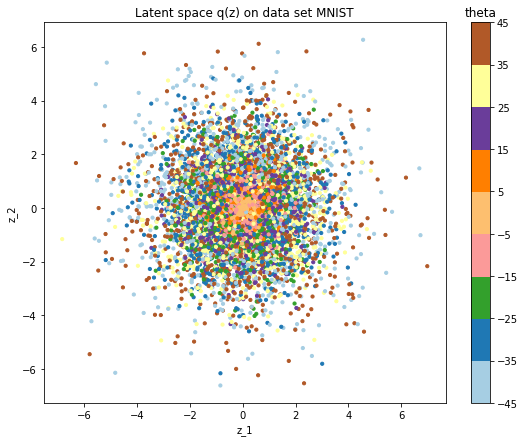

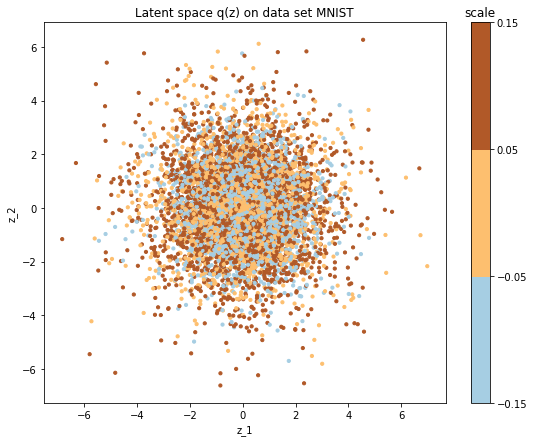

In [6]:
# visualize q(z) (latent space z)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    if solver.data_loader.thetas:
        ticks = np.arange(np.degrees(solver.data_loader.theta_range_2[0]), np.degrees(solver.data_loader.theta_range_2[1])+1, 10).tolist()
        labels = np.degrees(rand_transformation.prepro_params["theta_diff"]).tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="theta", labels=labels, colors=len(ticks)-1)
    if solver.data_loader.scales:
        ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_2[0]*10),\
                                                       int((solver.data_loader.scale_range_2[1]+0.1)*10))]
        ticks = np.linspace(solver.data_loader.scale_range_2[0], solver.data_loader.scale_range_2[1], 4)
        labels = rand_transformation.prepro_params["scale_diff"].tolist()
        plot_latent_space(solver, z_space, ticks=ticks, var="z", title="scale", labels=labels, colors=len(ticks)-1) # len(ticks)-1
else:
    print("Plot of latent space not possible as dimension of z is not 2")

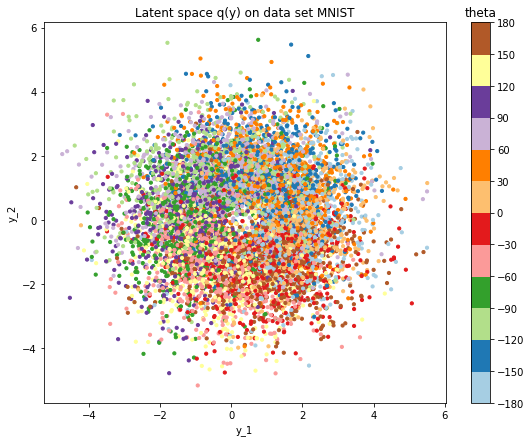

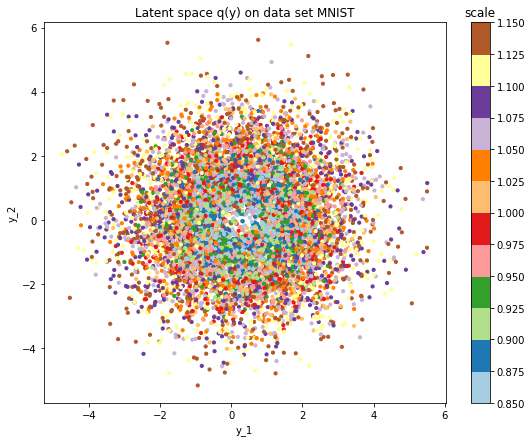

In [7]:
# visualize q(y)
if solver.model.z_dim == 2 and solver.data_loader.thetas or solver.data_loader.scales:
    if solver.data_loader.thetas:
        ticks = np.arange(np.degrees(solver.data_loader.theta_range_1[0]), np.degrees(solver.data_loader.theta_range_1[1])+1, 30).tolist()
        labels = np.degrees(rand_transformation.prepro_params["theta_1"]).tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="theta", labels=labels)
    if solver.data_loader.scales:
        ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
        labels = rand_transformation.prepro_params["scale_1"].tolist()
        plot_latent_space(solver, y_space, ticks=ticks, var="y", title="scale", labels=labels)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

True True
torch.Size([100, 1, 28, 28]) 0 0
2.96397889652642 3.6009049775810102 0.9093832155942101 1.012885247885565 0 0 1
-2.2232579008401117 -2.1127495401482426 1.1397422181225327 1.2118577072375996 1 1 2
-0.48125673985394624 -0.591742608879164 0.9164322083987849 0.8238923146708107 2 2 3
-1.9112458094307259 -1.4635381597033899 1.0451183349811295 1.156141109596474 3 3 4
-0.4479331112714733 -0.45468290160545977 1.0960027522181686 1.2025230636187336 4 4 5
-2.4084085093274807 -1.97739239044949 0.9308989023919234 0.9704415047680133 5 5 6
-1.1476964029911945 -1.1492321682874849 1.0903483442655304 0.9438812725516257 6 6 7
-2.104905935196928 -2.0890838382319874 0.9732489579659045 1.0142010150100755 7 7 8
-0.964648986082489 -1.3699026761802586 0.8825285291778885 0.7796893282176435 8 8 9
-2.073887502463224 -2.823655698380571 1.0066556472122226 1.0825272264378016 9 9 10
2.3995942034916844 2.7266362721251216 0.9014120783564704 0.8367748688722382 10 10 11
1.5562847484565738 1.3830152453291158 0.99

-0.09529996 1.0877154
-0.101613015 1.0930482
-0.10721311 1.0982214
-0.09099594 1.0736216
-0.088178515 1.0740533
-0.08844401 1.0739883
-0.08850415 1.076604
-0.089430645 1.0779382
-0.09070036 1.0763096
-0.09269449 1.0758144
-0.09389922 1.0772332
-0.09392064 1.0790387
-0.0922135 1.0823909
-0.09474191 1.0893472
-0.10100889 1.0671672
-0.09589979 1.0677861
-0.09227872 1.0692965
-0.09383349 1.0705595
-0.09472467 1.0730307
-0.09588988 1.0746491
-0.09454012 1.0756456
-0.09301624 1.0774838
-0.09076789 1.0768777
-0.08849354 1.0755116
-0.09609637 1.0782069
-0.10889447 1.0490367
-0.10696614 1.0533692
-0.10186806 1.0573041
-0.098110095 1.0607316
-0.09843896 1.06042
-0.09669137 1.0578333
-0.09461762 1.0577372
-0.09164587 1.0576189
-0.08758277 1.0566813
-0.08345477 1.0555614
-0.08101382 1.0562307
-0.09741286 1.0508978
-0.10721573 1.0499842
-0.11260277 1.0501734
-0.10540518 1.0516669
-0.097985044 1.051814
-0.095390856 1.051907
-0.09248744 1.0548596
-0.08966246 1.0560358
-0.08605038 1.0546582
-0.0818983

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.1278685 1.1052393
-0.1278832 1.1098988
-0.12709546 1.1157273
-0.13470292 1.0768684
-0.13474074 1.0815691
-0.13444328 1.0861654
-0.13453603 1.0893472
-0.1354695 1.0915809
-0.13689476 1.0936834
-0.13826954 1.0955731
-0.13869011 1.0970135
-0.13749558 1.1007563
-0.13781959 1.1060418
-0.13858119 1.111176


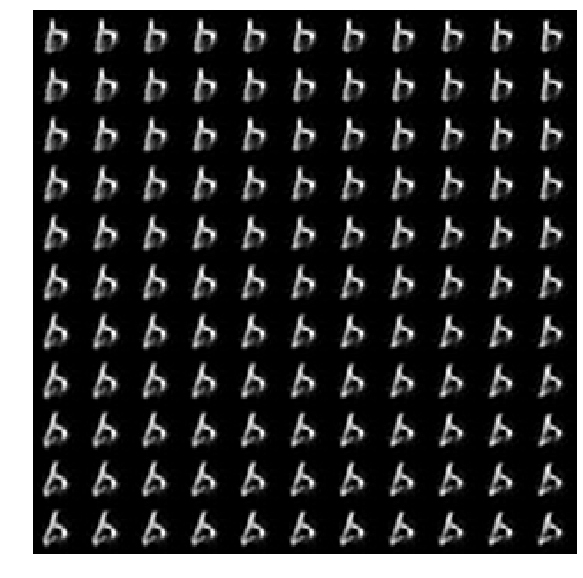

In [8]:
# Visualizations of learned q(z) for generative models with two-dimensional latent space
if solver.model.z_dim == 2:
    n = 11
    if solver.data_loader.thetas and solver.data_loader.scales:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)
    elif solver.data_loader.thetas:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)
    elif solver.data_loader.scales:
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-0.5, -3, n)
    test_loader = solver.data_loader.get_new_test_data_loader()
    x_t = iter(test_loader).next()[0]
    print(rand_transformation.rotations, rand_transformation.scaling)
    x_t, _ = rand_transformation.preprocess_samples(x_t, 0, 0, save=False)
    x_t = x_t[0].view(-1, solver.data_loader.input_dim)
    plot_latent_manifold(solver, "bone", grid_x, grid_y, n=n, x_t=x_t)
else:
    print("Plot is not possible as dimension of z is not 2 or model is loaded")

In [ ]:
# show how the transformation actually produces results in practice.
test_loader = solver.data_loader.get_new_test_data_loader()
file_name = solver.data_loader.directories.result_dir + "/plot_transformed_images_"\
            + solver.data_loader.dataset + ".png"
plot_transformed_images(test_loader, solver.data_loader.batch_size, save_image=solver.data_loader.directories.make_dirs, file_name=file_name)

In [ ]:
import math
import matplotlib.pyplot as plt
def show_img(batch, window_size):
  batch_size = batch.shape[0]
  grid0 = int(math.ceil(batch_size**0.5))
  grid1=int(math.ceil(batch_size/grid0))
  fig = plt.figure(figsize=(window_size, window_size))
  plt.subplots_adjust(hspace=0.05, wspace=0.025)
  samples = batch
  for i, sample in enumerate(samples):
    ax = plt.subplot(grid0, grid1, i + 1)
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(batch.shape[1], batch.shape[2]), cmap='Greys_r')
  plt.show()

In [ ]:
from preprocessing import test_batch
xs = next(iter(solver.data_loader.train_loader))
print(xs[0].shape)
x_t, x_next, _ = test_batch(xs[0], None, np.pi/4)
#print(x_t.view((100, 28, 28)).shape)
#print(x_t.shape, x_next.shape)
x_t = x_t.view((100, 28, 28))
x_next = x_next.view((100, 28, 28))
#x_t = xs[0][0][:100].numpy()
#x_next = xs[0][1][:100].numpy()
show_img(x_t, 5)
show_img(x_next, 5)
show_img(x_t - x_next, 5)

In [ ]:
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    test_loader = solver.data_loader.get_new_test_data_loader()
    num_rotations = 30
    num_scales = 30
    num_samples = 20
    det_transformation = DeterministicPreprocessing(num_samples, solver.data_loader.img_dims,\
                                                num_rotations, num_scales)
    ys = np.zeros((det_transformation.scales.shape[0], det_transformation.thetas.shape[0], num_samples, 2))
    transform_images(solver, det_transformation, test_loader, ys)
    if solver.data_loader.directories.make_dirs:
        torch.save(ys, solver.data_loader.directories.result_dir + "/ys.pt")

[0.         0.21666156 0.43332312 0.64998469 0.86664625 1.08330781
 1.29996937 1.51663094 1.7332925  1.94995406 2.16661562 2.38327719
 2.59993875 2.81660031 3.03326187 3.24992343 3.466585   3.68324656
 3.89990812 4.11656968 4.33323125 4.54989281 4.76655437 4.98321593
 5.1998775  5.41653906 5.63320062 5.84986218 6.06652374 6.28318531] [0.7        0.72068966 0.74137931 0.76206897 0.78275862 0.80344828
 0.82413793 0.84482759 0.86551724 0.8862069  0.90689655 0.92758621
 0.94827586 0.96896552 0.98965517 1.01034483 1.03103448 1.05172414
 1.07241379 1.09310345 1.1137931  1.13448276 1.15517241 1.17586207
 1.19655172 1.21724138 1.23793103 1.25862069 1.27931034 1.3       ]
sample 0
sample 1
sample 2
sample 3
sample 4
sample 5
sample 6
sample 7
sample 8
sample 9
sample 10
sample 11
sample 12
sample 13
sample 14
sample 15
sample 16
sample 17
sample 18
sample 19
Thetas applied: [  0.          12.4137931   24.82758621  37.24137931  49.65517241
  62.06896552  74.48275862  86.89655172  99.31034483 111

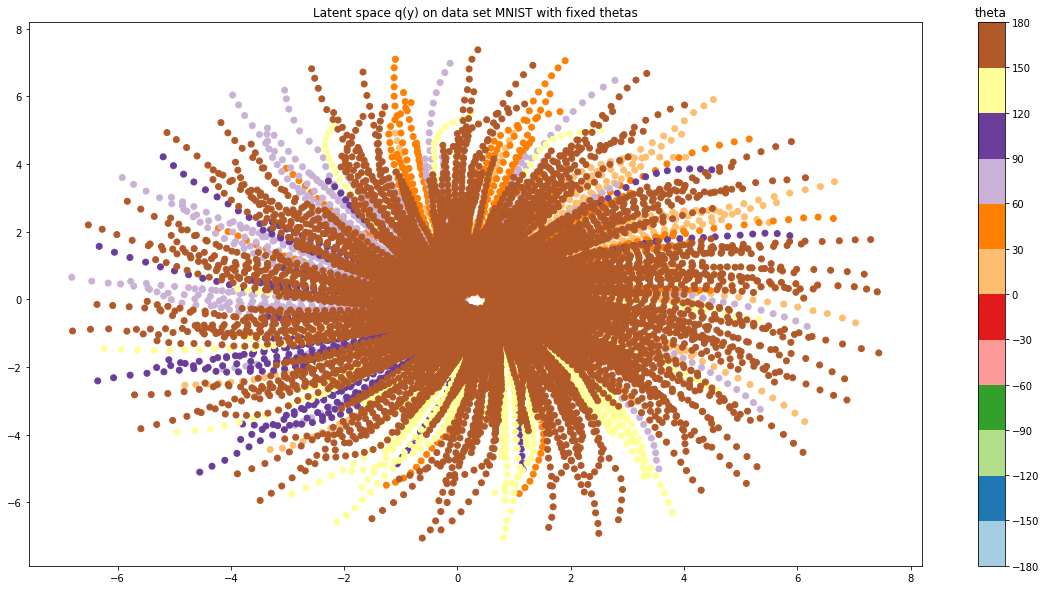

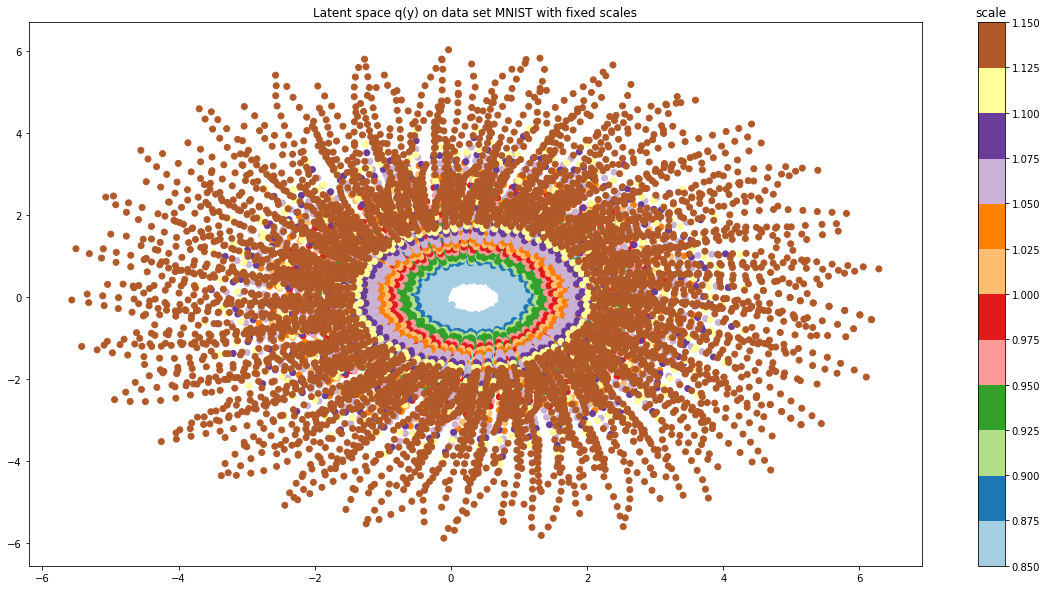

In [63]:
# TODO: just test like Oswin does..
test_loader = solver.data_loader.get_new_test_data_loader()
num_rotations = 30
num_scales = 30
num_samples = 20
from auxiliary import transform_images2
det_transformation = DeterministicPreprocessing(num_samples, solver.data_loader.img_dims,\
                                                num_rotations, num_scales)
ys2 = np.zeros((num_samples, num_scales, num_rotations, 2))
print(det_transformation.thetas, det_transformation.scales)
transform_images2(model, solver, det_transformation, test_loader, ys2, det_transformation.thetas, det_transformation.scales)
# thetas [0, 360], thetas_2 [0 , 60]
# scale [0.7, 1.3], scale [0.2, 0.5]
ticks = np.arange(np.degrees(solver.data_loader.theta_range_1[0]), np.degrees(solver.data_loader.theta_range_1[1])+1, 30).tolist()
labels = np.degrees(det_transformation.thetas)
print("Thetas applied: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_thetas_fixed_"\
          + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_thetas(ys2, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)
labels = det_transformation.scales
ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
#ticks = np.around(ticks, decimals=2)
print(labels, ticks)
print("Scales: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_scales_fixed_"\
            + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_scales(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

In [14]:
# Uncomment to load y spaces for plotting
# ys = torch.load("../results/tdcvae/MNIST_z=2_0/ys.pt")

In [50]:
test_loader = solver.data_loader.get_new_test_data_loader()
x_t, _ = iter(test_loader).next()
x0 = x_t.view(-1, 784).numpy()

In [51]:
from auxiliary import transform_batch

theta = np.linspace(0,1,30) * 2 * np.pi #angles
s =  0.7 + np.linspace(0,1,30) * 0.6 #scales
#compute feature responses
ys = np.zeros((20, s.shape[0], theta.shape[0], 2))
for sample in range(ys.shape[0]):
  #create one copy of the sample for each theta we want to use
  x0tile=np.reshape(np.tile(x0[sample:sample+1,:],[theta.shape[0],1]), (theta.shape[0],28,28))
  for i in range(s.shape[0]):
    #transform images and feed to the encoder, pick the mean opf y
    x0trans=transform_batch(x0tile, theta, s[i]*np.ones(theta.shape[0]))
    x0trans=np.reshape(x0trans,(theta.shape[0],784))
    ys[sample,i,:,:] = model.encoder(torch.FloatTensor(x0trans))[0].detach().numpy()

[0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0, 360.0]
Thetas applied: [  0.          12.4137931   24.82758621  37.24137931  49.65517241
  62.06896552  74.48275862  86.89655172  99.31034483 111.72413793
 124.13793103 136.55172414 148.96551724 161.37931034 173.79310345
 186.20689655 198.62068966 211.03448276 223.44827586 235.86206897
 248.27586207 260.68965517 273.10344828 285.51724138 297.93103448
 310.34482759 322.75862069 335.17241379 347.5862069  360.        ]
[0.7, 0.75, 0.7999999999999999, 0.8499999999999999, 0.8999999999999999, 0.95, 0.9999999999999999, 1.0499999999999998, 1.0999999999999999, 1.15, 1.1999999999999997, 1.2499999999999998, 1.2999999999999998]
Scales: [0.7        0.72068966 0.74137931 0.76206897 0.78275862 0.80344828
 0.82413793 0.84482759 0.86551724 0.8862069  0.90689655 0.92758621
 0.94827586 0.96896552 0.98965517 1.01034483 1.03103448 1.05172414
 1.07241379 1.09310345 1.1137931  1.13448276 1.15517241 1.17586207
 1.19655172 1.217241

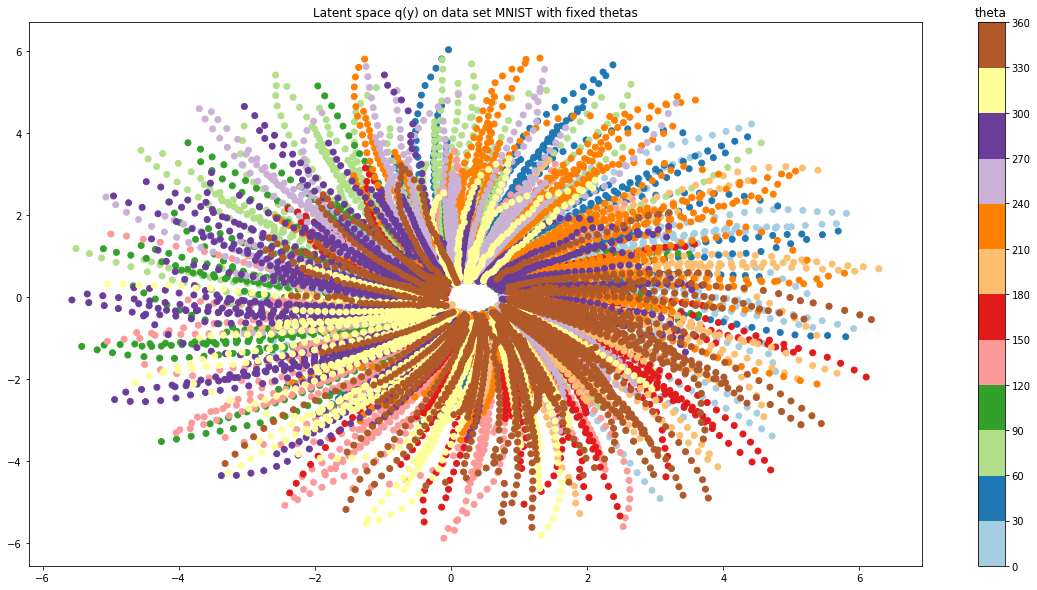

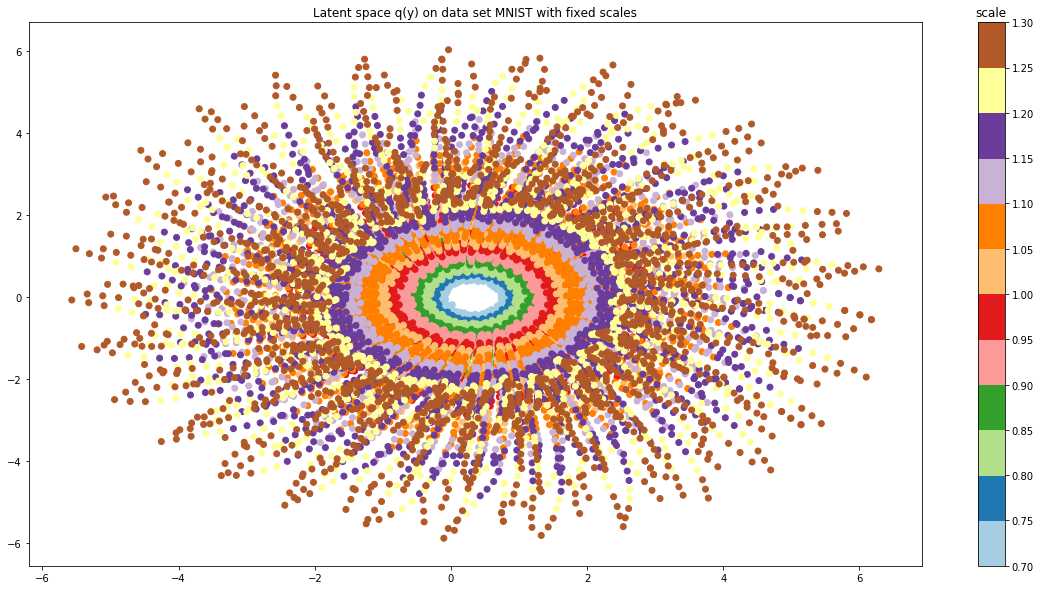

In [57]:
ticks = np.arange(np.degrees(theta[0]), np.degrees(theta[-1])+1, 30).tolist()
labels = np.degrees(theta)
print("Thetas applied: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_thetas_fixed_"\
          + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_thetas(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)
labels = s #sdet_transformation.scales
ticks = np.linspace(s[0], s[-1], 13).tolist()
print("Scales: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_scales_fixed_"\
            + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_scales(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

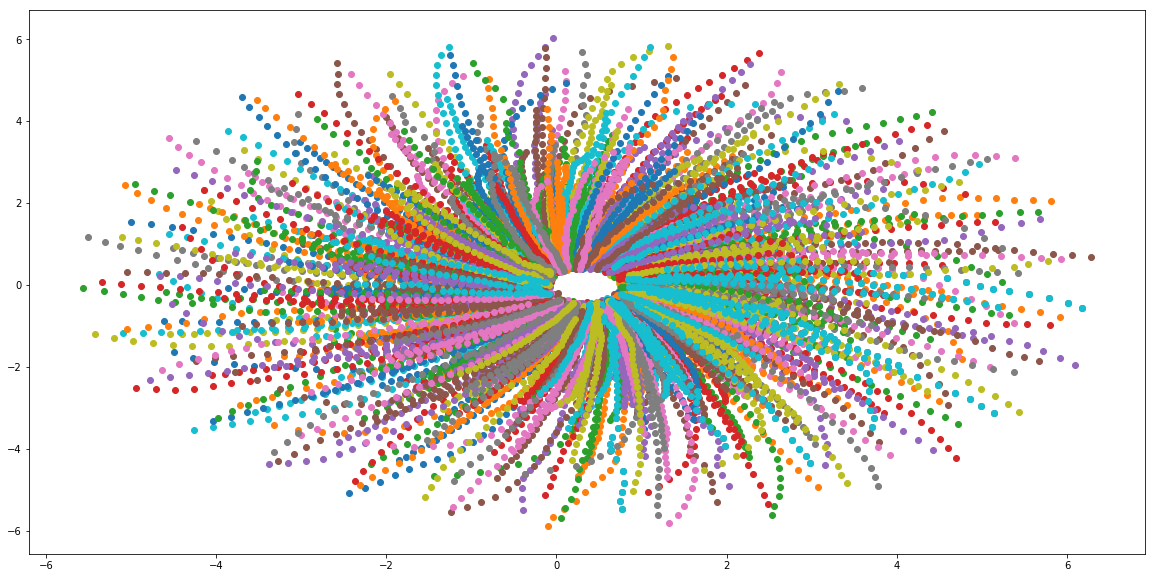

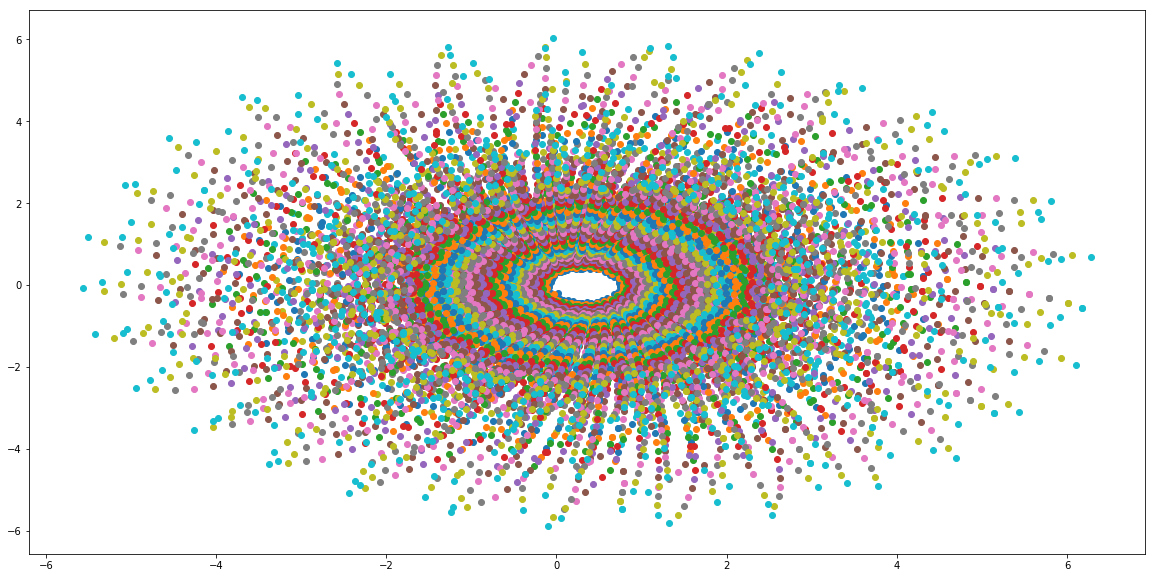

Thetas applied: [-180.         -167.5862069  -155.17241379 -142.75862069 -130.34482759
 -117.93103448 -105.51724138  -93.10344828  -80.68965517  -68.27586207
  -55.86206897  -43.44827586  -31.03448276  -18.62068966   -6.20689655
    6.20689655   18.62068966   31.03448276   43.44827586   55.86206897
   68.27586207   80.68965517   93.10344828  105.51724138  117.93103448
  130.34482759  142.75862069  155.17241379  167.5862069   180.        ]
[0.85       0.86034483 0.87068966 0.88103448 0.89137931 0.90172414
 0.91206897 0.92241379 0.93275862 0.94310345 0.95344828 0.9637931
 0.97413793 0.98448276 0.99482759 1.00517241 1.01551724 1.02586207
 1.0362069  1.04655172 1.05689655 1.06724138 1.07758621 1.08793103
 1.09827586 1.10862069 1.11896552 1.12931034 1.13965517 1.15      ] [0.85, 0.875, 0.8999999999999999, 0.9249999999999999, 0.95, 0.975, 1.0, 1.025, 1.0499999999999998, 1.075, 1.0999999999999999, 1.125, 1.15]
Scales: [0.85       0.86034483 0.87068966 0.88103448 0.89137931 0.90172414
 0.91206

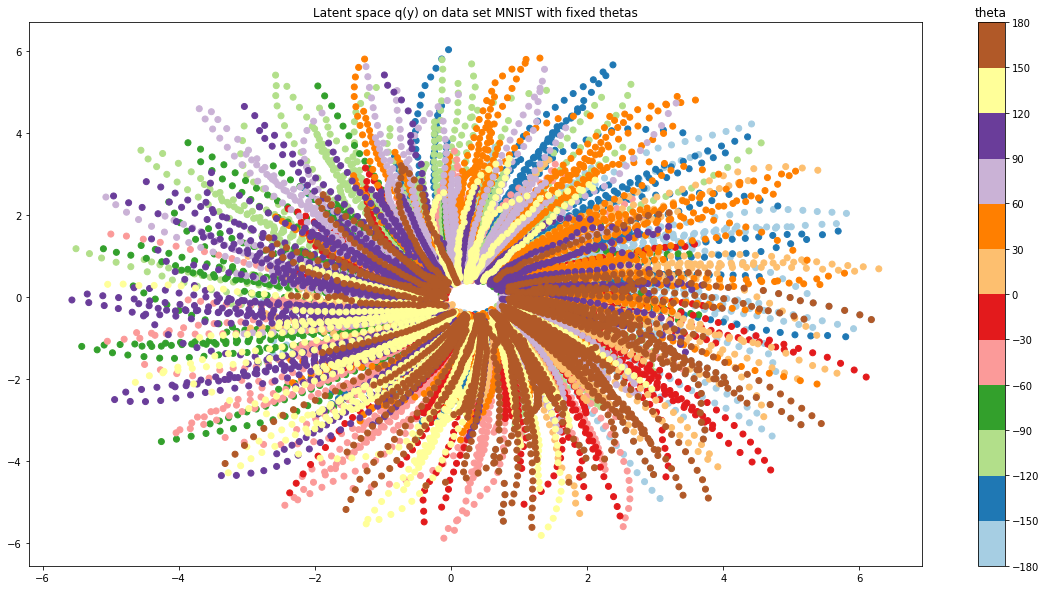

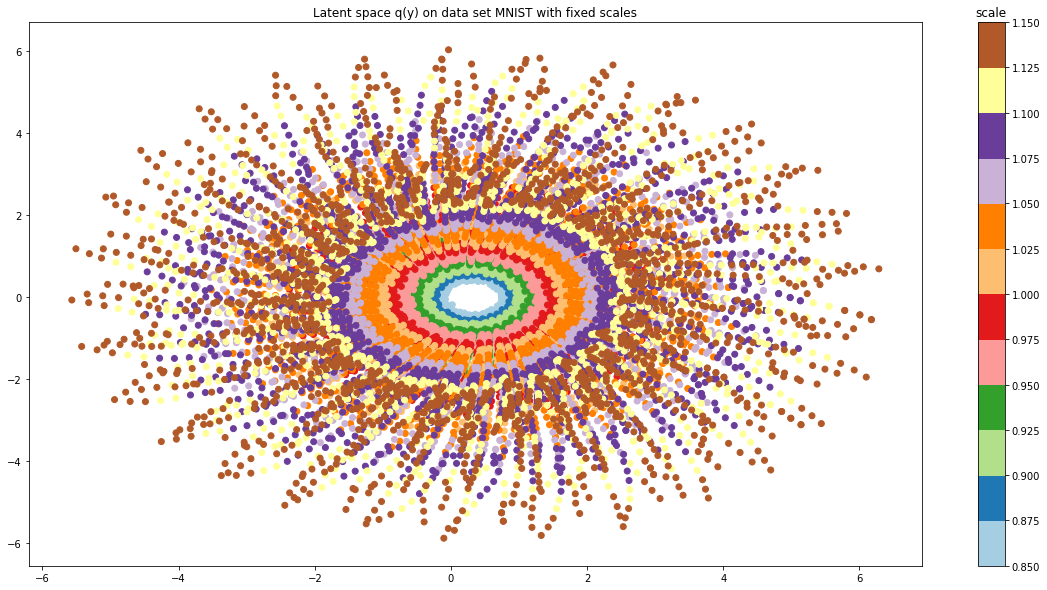

In [52]:
#scatter plot of responses, color-coded by theta
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for t in range(num_rotations):
  plt.scatter(ys[:,:,t,0],ys[:,:,t,1])
plt.show()

#scatter plot of responses, color-coded by scale
plt.figure(figsize=(20,10))
for scale in range(num_scales):
  plt.scatter(ys[:,scale,:,0],ys[:,scale,:,1])
plt.show()

ticks = np.arange(np.degrees(solver.data_loader.theta_range_1[0]), np.degrees(solver.data_loader.theta_range_1[1])+1, 30).tolist()
labels = np.degrees(det_transformation.thetas)
print("Thetas applied: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_thetas_fixed_"\
          + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_thetas(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)
labels = det_transformation.scales
ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
#ticks = np.around(ticks, decimals=2)
print(labels, ticks)
print("Scales: {}".format(labels))
file_name = solver.data_loader.directories.result_dir + "/plot_y_space_scales_fixed_"\
            + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
plot_y_space_scales(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

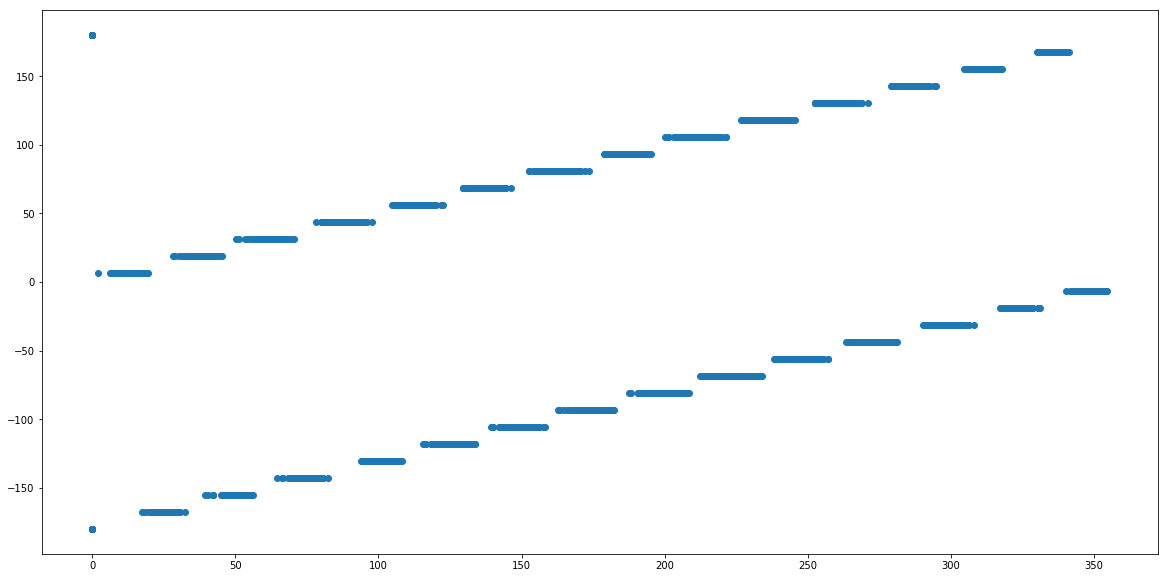

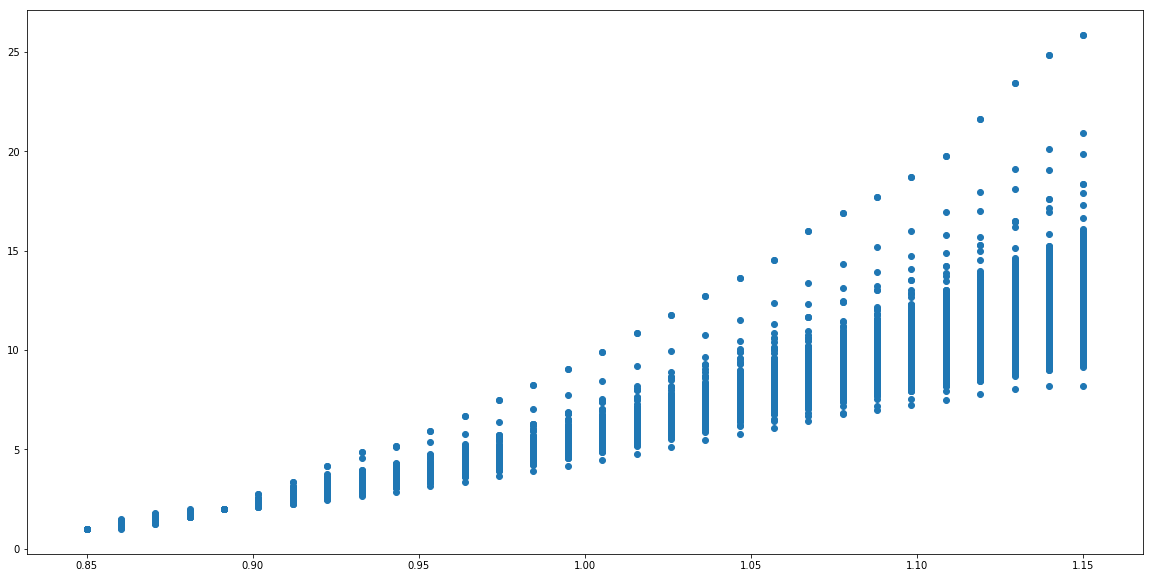

In [53]:
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1] * ys.shape[2],2))
meany=np.mean(ysflat,0,keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas= np.reshape(alphas,(ys.shape[0] * det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)

#create alpha-theta plot
thetaForScatter=np.tile(np.expand_dims(det_transformation.thetas,axis=0),(alphas.shape[0],1))/(2*np.pi) * 360
plt.figure(figsize=(20,10))
plt.scatter(alphas.flatten(), thetaForScatter.flatten())
plt.show()

#compute radius
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1] * ys.shape[2],2))
meany=np.mean(ysflat,0,keepdims=True)
rs= np.sqrt(np.sum((ysflat-meany)**2,axis=1))
rs= np.reshape(rs,(ys.shape[0], det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

#normalize radii to scale [0,1] for each sample
rs /= rs[:,4:5,:]-rs[:,0:1,:]
rs += 1 - rs[:,0:1,:]

#create scale-radius plot
scaleForScatter = np.expand_dims(np.expand_dims(det_transformation.scales,axis=0),axis=2)
scaleForScatter=np.tile(scaleForScatter,(ys.shape[0],1, det_transformation.thetas.shape[0]))
plt.figure(figsize=(20,10))
plt.scatter(scaleForScatter.flatten(), rs.flatten())
plt.show()

In [ ]:
# scatter plot of the ys with thetas
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    ticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
    labels = det_transformation.thetas
    print("Thetas applied: {}".format(labels))
    file_name = solver.data_loader.directories.result_dir + "/plot_y_space_thetas_fixed_"\
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_y_space_thetas(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

In [ ]:
# scatter plot of the ys with scales
if solver.data_loader.thetas and solver.data_loader.scales and solver.model.z_dim == 2:
    labels = det_transformation.scales
    ticks = np.linspace(solver.data_loader.scale_range_1[0], solver.data_loader.scale_range_1[1], 13).tolist()
    ticks = np.around(ticks, decimals=2)
    print("Scales: {}".format(labels))
    file_name = solver.data_loader.directories.result_dir + "/plot_y_space_scales_fixed_"\
                + solver.data_loader.dataset + "_z=" + str(solver.model.z_dim) + ".png"
    plot_y_space_scales(ys, ticks, labels, solver.data_loader.directories.make_dirs, file_name, solver.data_loader.dataset)

In [ ]:
# for rotation
if solver.z_dim == 2 and solver.data_loader.thetas:
    plot_prepro_alpha_params_distribution(solver)
else:
    print("dim(z) is not 2 or rotation mode is not set")

In [ ]:
# for scaling
if solver.z_dim == 2 and solver.data_loader.scales:
    plot_prepro_radius_params_distribution(solver)
else:
    print("dim(z) is not 2 or scaling mode is not set")

In [ ]:
#compute alphas
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1]*ys.shape[2], 2))
meany=np.mean(ysflat, 0, keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
alphas= np.reshape(alphas, (ys.shape[2] * det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

print(det_transformation.thetas.shape)
print(np.min(alphas), np.max(alphas))
print(alphas.shape)

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)


thethos = np.repeat(det_transformation.thetas, alphas.shape[0])
#print(np.min(alphas), np.max(alphas), alphas.shape)
#print(thethos.shape, thethos[19998:20003])
#plt.scatter(thetas[200,:], alphas[200,:])
#plt.scatter(thetas[201,:], alphas[201,:])
#thethos = transformation.thetas # np.tile(np.expand_dims(theta,axis=0),(alphas.shape[0],1))/(2*np.pi)/360
#plt.figure(figsize=(20,10))

print(thethos.shape, alphas.shape)
plt.scatter(thethos.flatten(), alphas.flatten())
plt.show()

#plt.scatter(thethos[200:210], alphas[200:210])
#plt.scatter(thethos[211], alphas[211])

In [ ]:
print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla


alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

#paired_cmap = plt.cm.get_cmap("Paired", 12)
#rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
#norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas), len(new_counts), indices, np.min(thetas[indices]), np.max(thetas[indices]))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=88.61_z=2.pt", map_location='cpu')
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()


alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
alphas = np.array([round(x,2) for x in alphas.tolist()])
# TODO: problem: for each batch_size, there are num_generation (thetas, alphas), we have to take that into account!
#thetas = np.repeat(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
classes = np.array(solver.data_labels)
#y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
#print(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
# TODO: make alphas bins and count, but then flatten the counts, and mark by counts values where each new color begins.
#print(np.sum(counts))
#print(alphas.shape, len(thetas), solver.y_space.shape, len(solver.data_loader.prepro_params["theta_1"]), classes)
# move every 10, because every 10th is the angle for index 0.
thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(thetas.shape)

paired_cmap = plt.cm.get_cmap("Paired", 12)
rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
print(alpha_bins)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    #print(counts.sum(), len(alphas_indices))
    #print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        #print(asd, offset, to_fill.shape)
        new_counts[asd:(asd+offset)] = to_fill # 0:len(to_fill), len(to_fill):len(new_to_fill)
        asd += offset
    print(len(new_counts))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()
# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for gen in range(solver.num_generations):
    thetas[:, gen] = np.radians(np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size))
#thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(alphas.shape, thetas.shape)
# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
    
print(alphas.shape, thetas.shape)
    #paired_cmap = plt.cm.get_cmap("Paired", 12)
    #rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
    #norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)

# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
# For each batch we go through num_generations iterations/encodings. Thus, 
# if num_generations is 10, for prepro_params, 0-9 is for batch 0, 10-19 for batch 1 and so on. (every time on the same batch)  
idx = 0
for batch_idx in range(solver.data_loader.num_train_batches):
    start = batch_idx*solver.data_loader.batch_size
    end = (batch_idx+1)*solver.data_loader.batch_size
    for gen in range(solver.num_generations):
        thetas[start:end, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][idx], solver.data_loader.batch_size)
        idx += 1
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)

mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
for idx in range(0, alphas.shape[1]):
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    if idx > 0:
        alphas[:, idx] = np.around(alphas[:, idx] - alphas[:, 0] + (np.radians(thetas[:, 0])/(2*np.pi))-0.5, decimals=2)
        #mini = np.min(alphas[:, idx])
        #maxi = np.max(alphas[:, idx])
        #print(mini, maxi)
        #print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))
        neg_indices = np.where(alphas[:, idx] < -0.5)
        pos_indices = np.where(alphas[:, idx] > 0.5)
        alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
        print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))

# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
alphas = np.around(np.array(alphas), decimals=2)

alpha_ranges = alpha_ranges[:-1]
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(np.radians(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

'''
alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

# compute the alphas
M, N, D = solver.y_space.shape
new_y_space = solver.y_space.reshape((N, M, D))
alphas = torch.zeros((new_y_space.shape[1], new_y_space.shape[2])) # used to be N, D
thetas = np.zeros_like(alphas)
#print(solver.y_space.shape, new_y_space.shape, alphas.shape)
#print(torch.tensor(solver.y_space[: idx, 0]-np.mean(solver.y_space[:, idx, 0])).shape)
for idx in range(solver.y_space.shape[0]):
    print("haha", (torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0]))))
    #alphas[:, idx] = torch.atan2(torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0])),\
    #        torch.tensor(new_y_space[:, idx, 1]-np.mean(new_y_space[:, idx, 1])))/(2*np.pi)
    #thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]

# TODO:oK?
alphas = torch.zeros((solver.y_space.shape[1], solver.y_space.shape[0]))
thetas = np.zeros_like(alphas)
for idx in range(solver.y_space.shape[0]):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] = alphas[:, idx]
'''

# M, N, 2
print(solver.data_loader.prepro_params["theta_1"].shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        
alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
print(alphas.shape, thetas.shape)
print(thetas[100:200])

# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, M), decimals=2)
alpha_ranges = alpha_ranges[:-1]
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        print(i, alphas_indices[:, i].shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thetas[indices].flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
plt.figure(figsize=(20,10))
#print(ys[:,:,0,0].shape)
#print(ys[:,:,0,0].shape)
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
for t in range(ys.shape[1]):
  plt.scatter(ys[:,t,:,0], ys[:,t,:,1])
plt.show()

plt.figure(figsize=(20,10))
for s in range(ys.shape[0]):
  plt.scatter(ys[s,:,:,0],ys[s,:,:,1])
plt.show()

In [ ]:
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1]*ys.shape[2], 2))
meany=np.mean(ysflat, 0, keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
# ys = np.zeros((transformation.scales.shape[0], transformation.thetas.shape[0], solver.data_loader.num_test_samples, 2))
alphas= np.reshape(alphas, (ys.shape[2] * det_transformation.scales.shape[0], det_transformation.thetas.shape[0]))

print(det_transformation.thetas.shape)
print(np.min(alphas), np.max(alphas))
print(alphas.shape)

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)


thethos = np.repeat(det_transformation.thetas, alphas.shape[0])
#print(np.min(alphas), np.max(alphas), alphas.shape)
#print(thethos.shape, thethos[19998:20003])
#plt.scatter(thetas[200,:], alphas[200,:])
#plt.scatter(thetas[201,:], alphas[201,:])
#thethos = transformation.thetas # np.tile(np.expand_dims(theta,axis=0),(alphas.shape[0],1))/(2*np.pi)/360
#plt.figure(figsize=(20,10))
plt.scatter(thethos.flatten(), alphas.flatten())
plt.show()

In [ ]:
print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

######################################################################

#solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
#solver.model.eval()

N, M = ys
M = 2
alphas = np.zeros((N, M))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))
alphas[:, 1] = torch.atan2(torch.tensor(solver.y_space[1, :, 0]-np.mean(solver.y_space[1, :, 0])),\
            torch.tensor(solver.y_space[1, :, 1]-np.mean(solver.y_space[1, :, 1])))
alphas = np.array(alphas)
alphas[:, 1] -= alphas[:, 0]
alphas /= (2*np.pi)/360
alphas = np.around(alphas, decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
thetas[:, 1] = solver.data_loader.prepro_params["theta_1"][1]
alphas = np.where(alphas >= 0, alphas, alphas+360)

print(thetas[:, 0])
print(thetas[:, 1])

'''
M=1
alphas = torch.zeros((N, 1))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
'''

'''
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        #neg_indices = np.where(alphas[:, idx] < -0.5)
        #pos_indices = np.where(alphas[:, idx] > 0.5)
        #alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        #alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
alphas = np.around(np.array(alphas), decimals=2)
'''
#solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
#solver.model.eval()

mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices, 1:] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices, 1:] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
'''
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1] * ys.shape[2],2))
meany=np.mean(ysflat,0,keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas= np.reshape(alphas,(ys.shape[0] * s.shape[0], theta.shape[0]))

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)
'''
solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
solver.model.eval()

print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])
'''
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
'''

'''
mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
'''

In [ ]:
radiuses = np.zeros((solver.y_space.shape[0], solver.num_generations))
centroid = np.mean(solver.y_space[:, :2], axis=0)
# compute the euclidean distance from each point y_{ij} to the center, so the radiuses
#print(solver.data_loader.train_loader.dataset.transform.transforms.prepro_params)
#print(solver.data_loader.prepro_params["scale_1"])
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)):
    radiuses[:, idx] = bla.cdist(solver.y_space[:, gen_idx:gen_idx+2], np.atleast_2d(centroid)).ravel()
    if idx > 0:
        radiuses[:, idx] -= radiuses[:, 0]
    #radiuses = np.around(np.array(radiuses), decimals=2)
    # prepare the scale from each batch, repeat each set of scales to span over num train samples
#print(solver.data_loader.prepro_params)
scales = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for idx in range(solver.num_generations):
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    scales[:, idx] = np.repeat(solver.data_loader.prepro_params["scale_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    # create the alphas bins, corresponding to the same number as theta bins
mini = np.min(radiuses)
maxi = np.max(radiuses)
radius_ranges = np.around(np.linspace(mini, maxi, 5), decimals=2)
radius_bins = list(zip(radius_ranges[:-1], radius_ranges[1:]))

fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10, 60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(radius_bins))
    radius_indices = radiuses[indices]
    for i in range(radiuses.shape[1]):
        for alpha in radius_indices[:, i]:
            for bin_idx, (x, y) in enumerate(radius_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(radius_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    scatter = ax.scatter(scales[indices, :].flatten(), radius_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)